# Models
All models are run on the test set i.e. a subset of the original data set. This is done on 200 different test sets and results are presented as average performance. 

The models included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Gendersort - Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model
- Reduced Xgboost regression model without sensitive attributes 
- Xgboost regression model account for diversity 


In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle


## Plots setup


In [2]:

def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 400
setup_mpl()



## Load dataset


In [3]:
df = pd.read_csv("X_test_STRATUM_y_test.csv")
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_for_Mergesort_single = df
df_new = pd.read_csv("NEW_X_test_y_test.csv") # this is just one df
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()

In [4]:
# Data containing 200 splits of X-test and y-test
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

# Mergesort Ranker

In [6]:
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

# For 200 splits
X_test_y_test_FULL = pd.DataFrame()
for i in range(200):
    dfs_test_use[i]= dfs_test_use[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use[i]= dfs_test_use[i].reset_index()
    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use[i])

X_test_y_test_FULL=X_test_y_test_FULL.drop(['STRATUM'], axis=1)



In [7]:
X_test_y_test_FULL['index_real'] = X_test_y_test_FULL.index
X_test_y_test_FULL=X_test_y_test_FULL.merge(GUDF_1[['Unnamed: 0','STRATUM','GENDER']], how='left',on='Unnamed: 0',sort=False)

### The stratum percentages for top-200 rankings

In [8]:
de_første = np.arange(0,200)
X_test_y_test_FULL_første = X_test_y_test_FULL.loc[X_test_y_test_FULL['index_real'].isin(de_første)]
X_test_y_test_FULL_første.STRATUM.value_counts(normalize=True)*100

3    29.5675
4    24.6150
5    15.1650
2    14.5100
6    13.3375
1     2.8050
Name: STRATUM, dtype: float64

### Preparing plotting with standard errors

In [9]:
X_test_y_test_FULL_std = X_test_y_test_FULL.groupby('index_real').std()/np.sqrt(200) #df with standard deviations of all columns in full df
X_test_y_test_FULL_mean=  X_test_y_test_FULL.groupby('index_real').mean() #means of all columns

X_test_y_test_FULL_mean["incr_col_mean"] = X_test_y_test_FULL_mean['18'].expanding().mean() #expanding mean of n of the means
X_test_y_test_FULL_std["incr_col_mean"] = X_test_y_test_FULL_std['18'].expanding().mean()
X_test_y_test_FULL_mean["incr_stratum"] = X_test_y_test_FULL_mean['STRATUM'].expanding().mean()

df_sort_BIG =X_test_y_test_FULL_mean

In [10]:
#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG["incr_half_std"] = 0.5*X_test_y_test_FULL_std["incr_col_mean"] #0.5 of std error to plot on both sides of mean
df_sort_BIG["lower_std"] = df_sort_BIG["incr_col_mean"] - df_sort_BIG["incr_half_std"]
df_sort_BIG["upper_std"] = df_sort_BIG["incr_col_mean"] + df_sort_BIG["incr_half_std"]

## Mergesort utility


findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


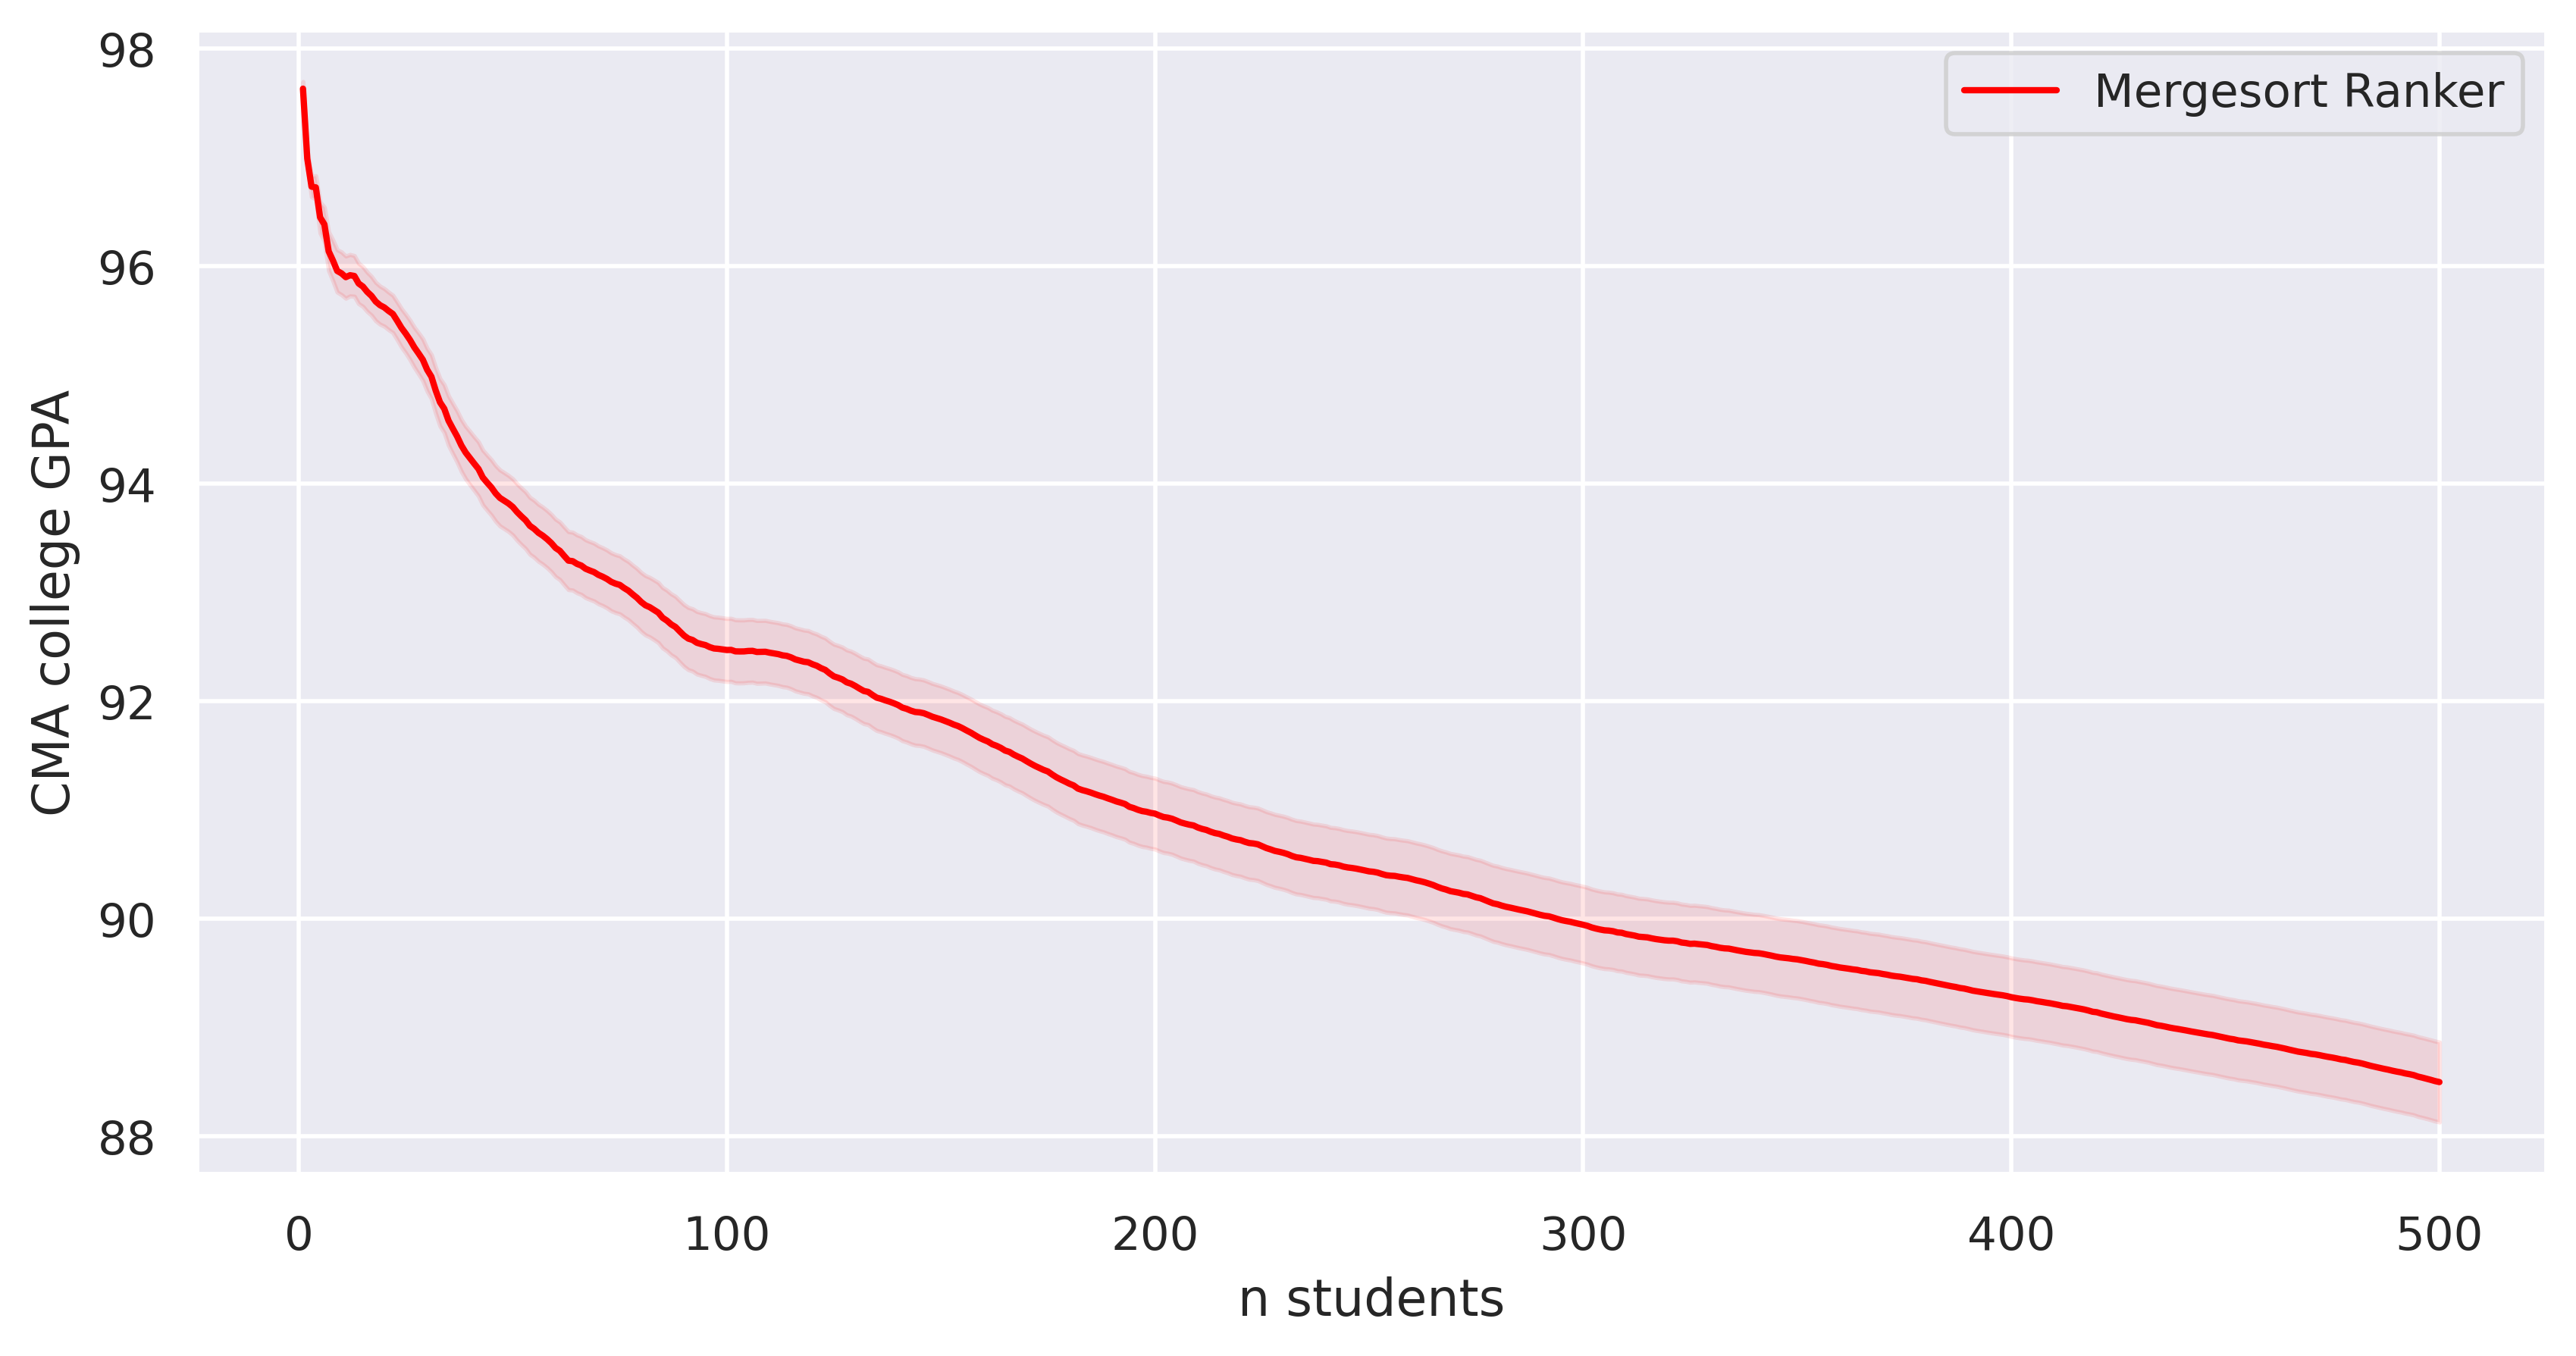

In [11]:
df_sort_BIG["n_students"] = range(1,len(df_sort_BIG)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[:500], color="red")#.set_title("Utility - College GPA, Mergesort")
plt.legend([ "Mergesort Ranker"], loc ="upper right")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG[:500], alpha=0.1, color="red")

plt.xlabel('n students')
plt.ylabel('CMA college GPA')
plt.show()

### Plotting mergesort and average stratum together

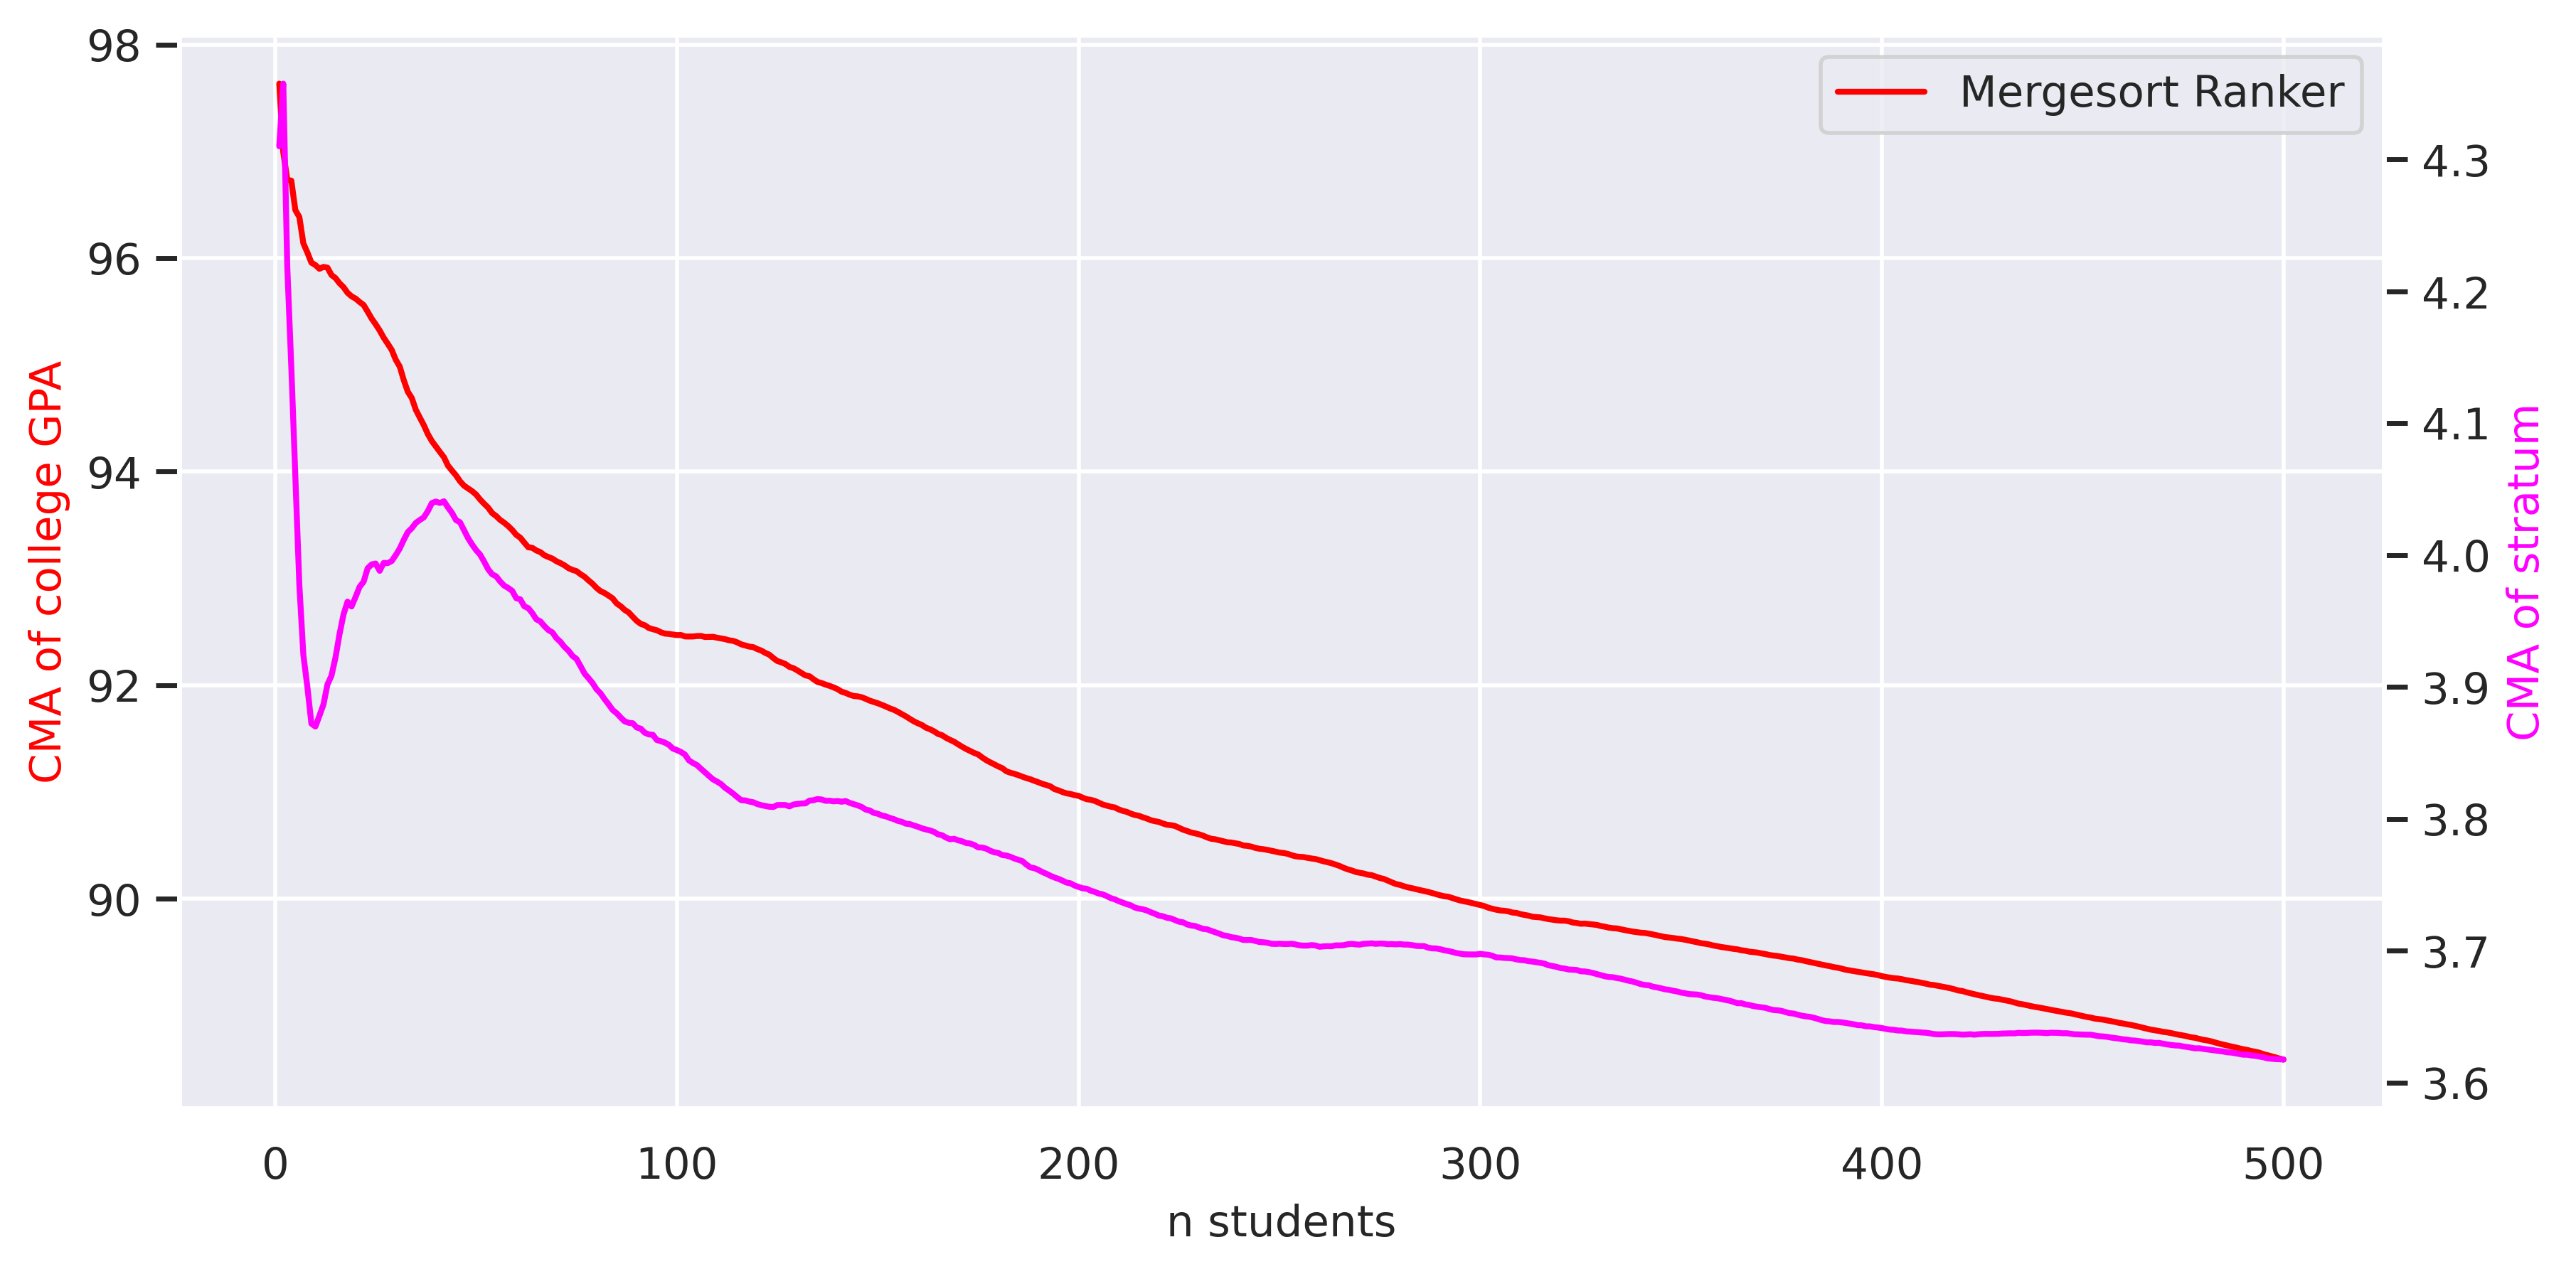

In [12]:
fig,ax = plt.subplots()
# make a plot

ax.plot(df_sort_BIG[:500].n_students, df_sort_BIG[:500].incr_col_mean, color="red")
# set x-axis label
ax.set_xlabel("n students",fontsize=11)
# set y-axis label
ax.set_ylabel("CMA of college GPA",color="red",fontsize=11)
plt.legend([ "Mergesort Ranker"], loc ="upper right")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sort_BIG[:500].n_students, df_sort_BIG[:500]["incr_stratum"],color="magenta")
ax2.set_ylabel("CMA of stratum",color="magenta",fontsize=11)
ax2.grid(None)

#plot
plt.xlabel('n students')
plt.ylabel('CMA of stratum')
plt.show()


# Gendersort Ranker 


In [13]:
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

def gender_mergesort_BIG(df):

    dfs_test_use = df 
    FEMALES = pd.DataFrame()
    MALES= pd.DataFrame()
 
    for i in range(200):
        fem=dfs_test_use[i][dfs_test_use[i]['4'] != 0]
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]


        fem= fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        mal= mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        fem = fem.merge(GUDF_1[['Unnamed: 0','STRATUM']], on='Unnamed: 0')
        mal = mal.merge(GUDF_1[['Unnamed: 0','STRATUM']], on='Unnamed: 0')

        FEMALES= FEMALES.append(fem)
        MALES=MALES.append(mal)



    FEMALES.index.names = ['INDEXES']
    MALES.index.names = ['INDEXES']

    #add std to plot it later
    FEMALES_std = FEMALES.groupby('INDEXES').std()/np.sqrt(200)
    MALES_std = MALES.groupby('INDEXES').std()/np.sqrt(200)
     
    FEMALES = FEMALES.groupby('INDEXES').mean().merge(FEMALES_std["18"], on="INDEXES", how="left")
    MALES = MALES.groupby('INDEXES').mean().merge(MALES_std["18"], on="INDEXES", how="left")
        
    if FEMALES['3'].max() > MALES['3'].max():
        sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()
        
    
    return sorted_with_gender.reset_index()
  

gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


### The stratum percentages for top-200 rankings

In [14]:
de_første = np.arange(0,200)
gender_df_BIG_første = gender_df_BIG.loc[gender_df_BIG.index.isin(de_første)]
gender_df_BIG_første.STRATUM_y.value_counts(normalize=True)*100

3.630    2.5
3.515    2.0
3.505    2.0
3.725    2.0
3.620    1.5
        ... 
3.450    0.5
3.310    0.5
3.700    0.5
4.200    0.5
3.495    0.5
Name: STRATUM_y, Length: 121, dtype: float64

In [15]:
gender_df_BIG["incr_col_mean"] = gender_df_BIG['18_x'].expanding().mean()
gender_df_BIG["incr_col_mean_std"] = gender_df_BIG['18_y'].expanding().mean()
gender_df_BIG["incr_stratum"] = gender_df_BIG['STRATUM_y'].expanding().mean()

gender_df_BIG["n_students"] = range(1,len(gender_df_BIG)+1)

In [16]:
#Adding standard deviation column for "incr_col_mean" and variables for plotting 200
gender_df_BIG["incr_half_std"] = 0.5*gender_df_BIG["incr_col_mean_std"] #0.5 of std to plot on both sides of mean
gender_df_BIG["lower_std"] = gender_df_BIG["incr_col_mean"] - gender_df_BIG["incr_half_std"]
gender_df_BIG["upper_std"] = gender_df_BIG["incr_col_mean"] + gender_df_BIG["incr_half_std"]

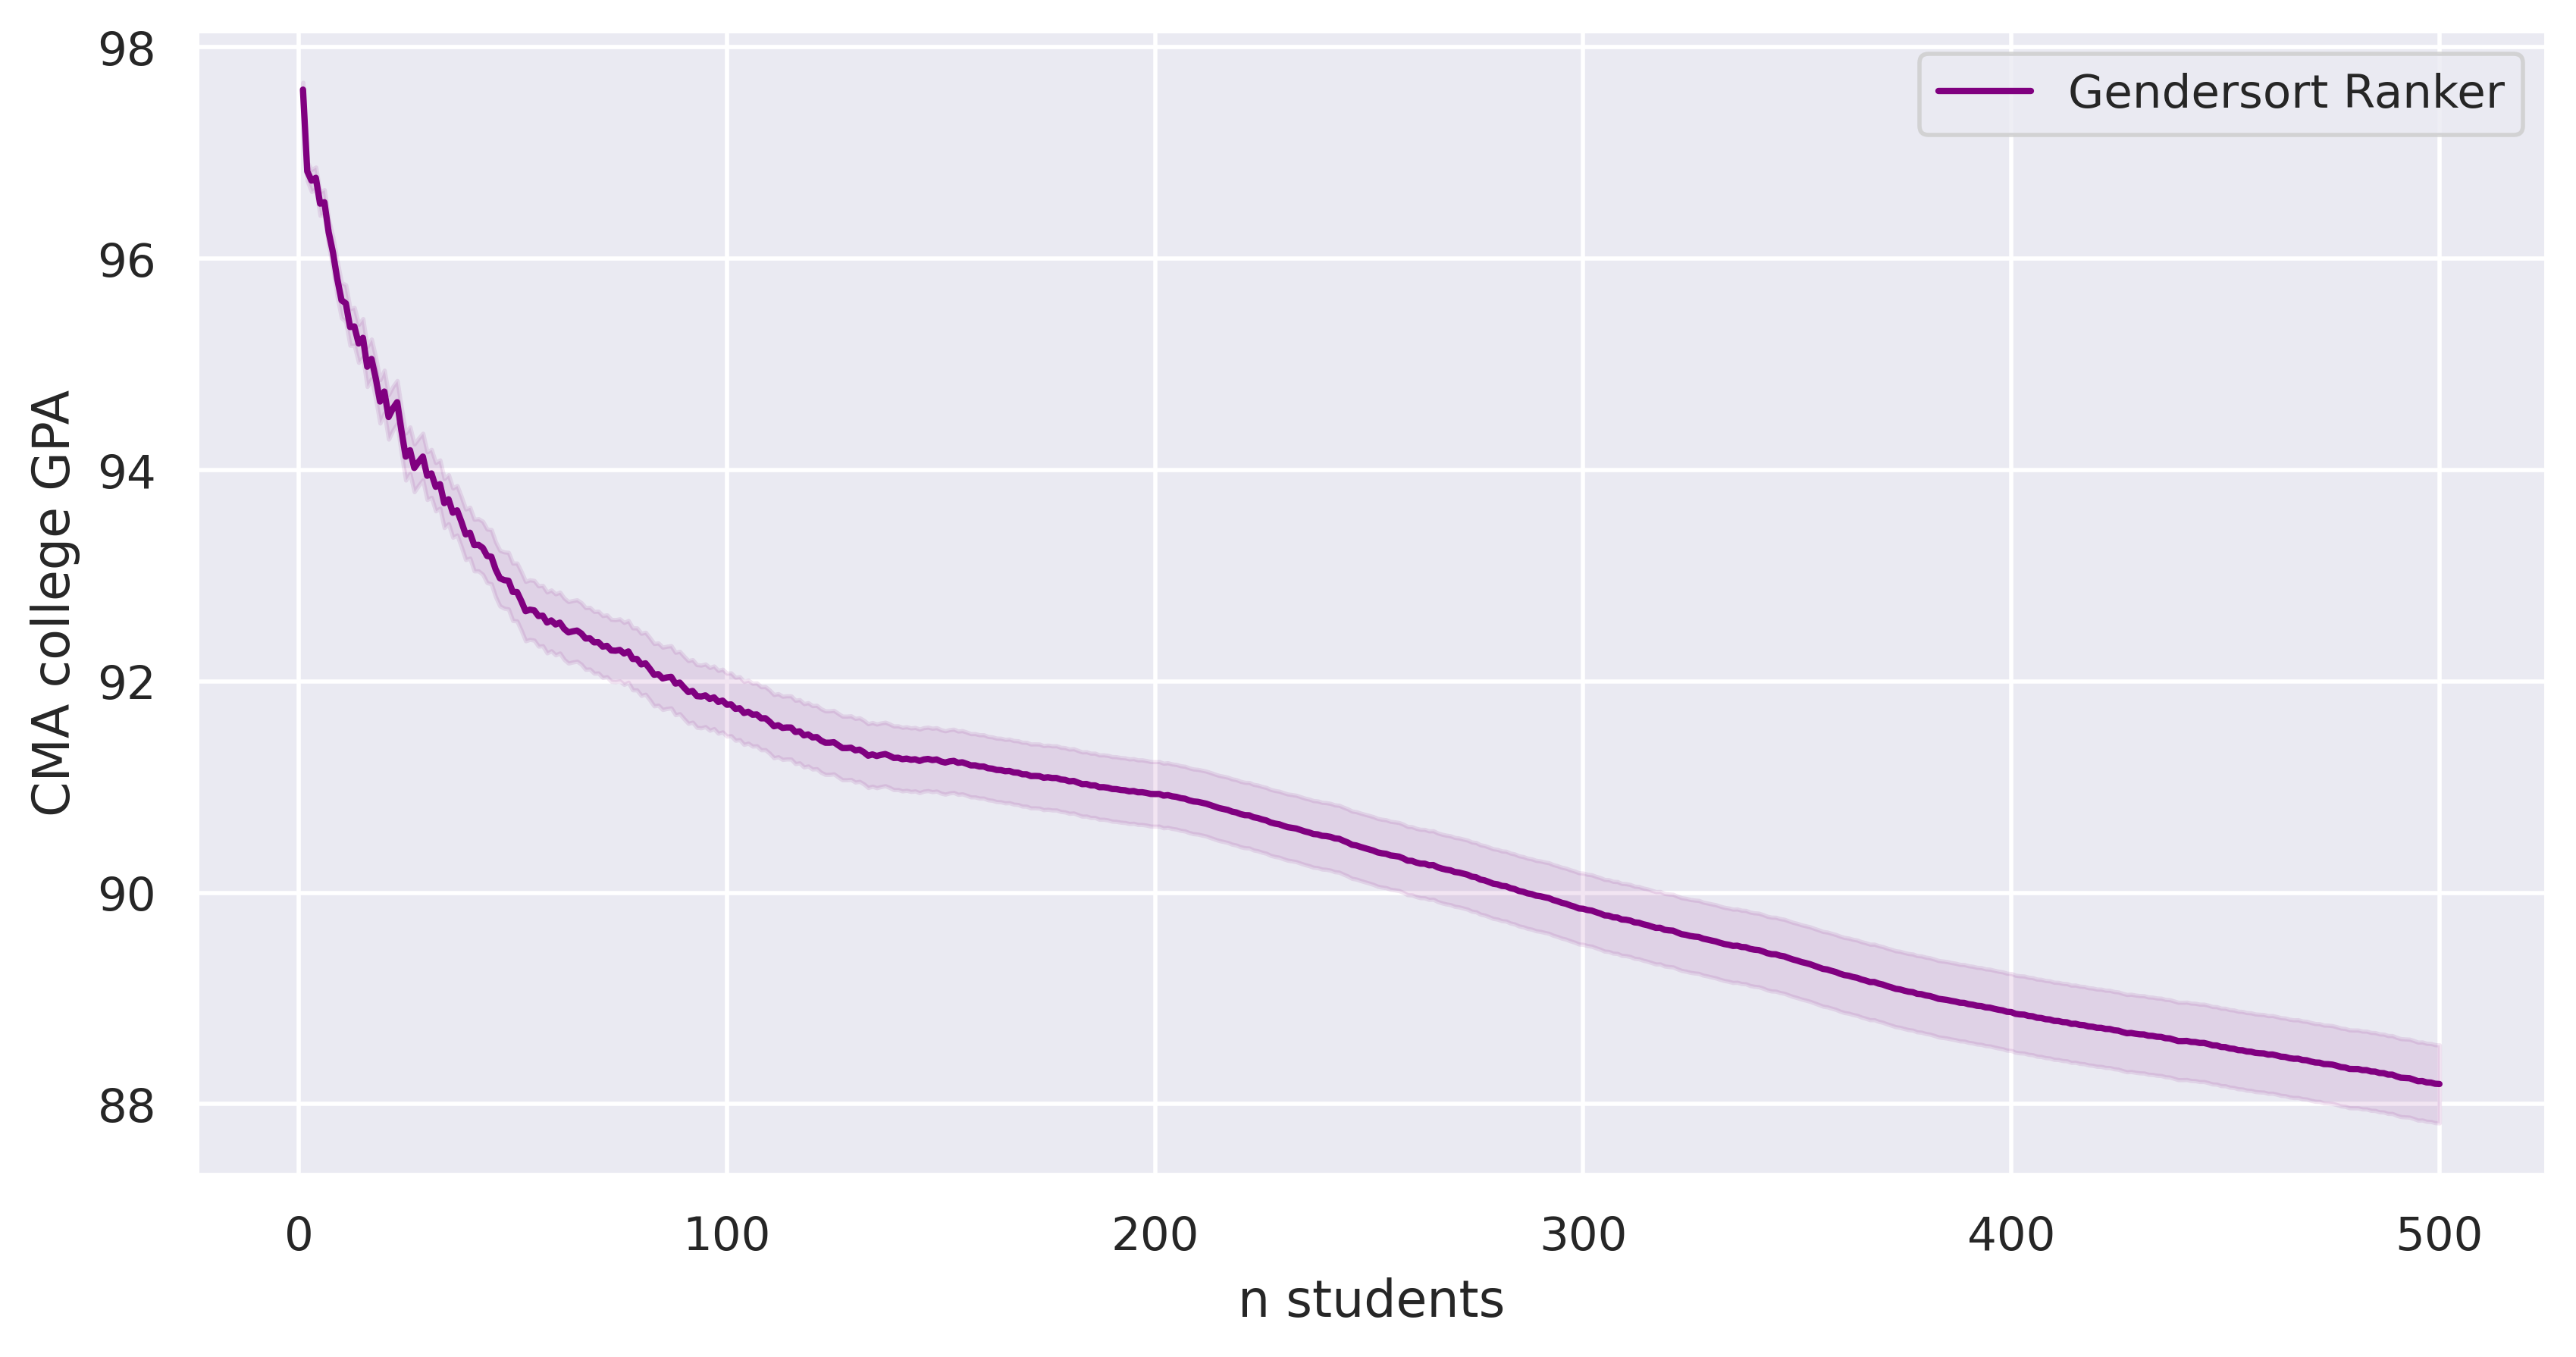

In [17]:
# The gendersort as function of n
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df_BIG[:500], color="purple")#.set_title("Utility - College GPA, Gendersort")
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG[0:500], alpha=0.1, color="purple")
plt.xlabel('n students')
plt.ylabel('CMA college GPA')
plt.legend(["Gendersort Ranker"], loc ="upper right")
plt.show()

### Plotting mergesort and average stratum together

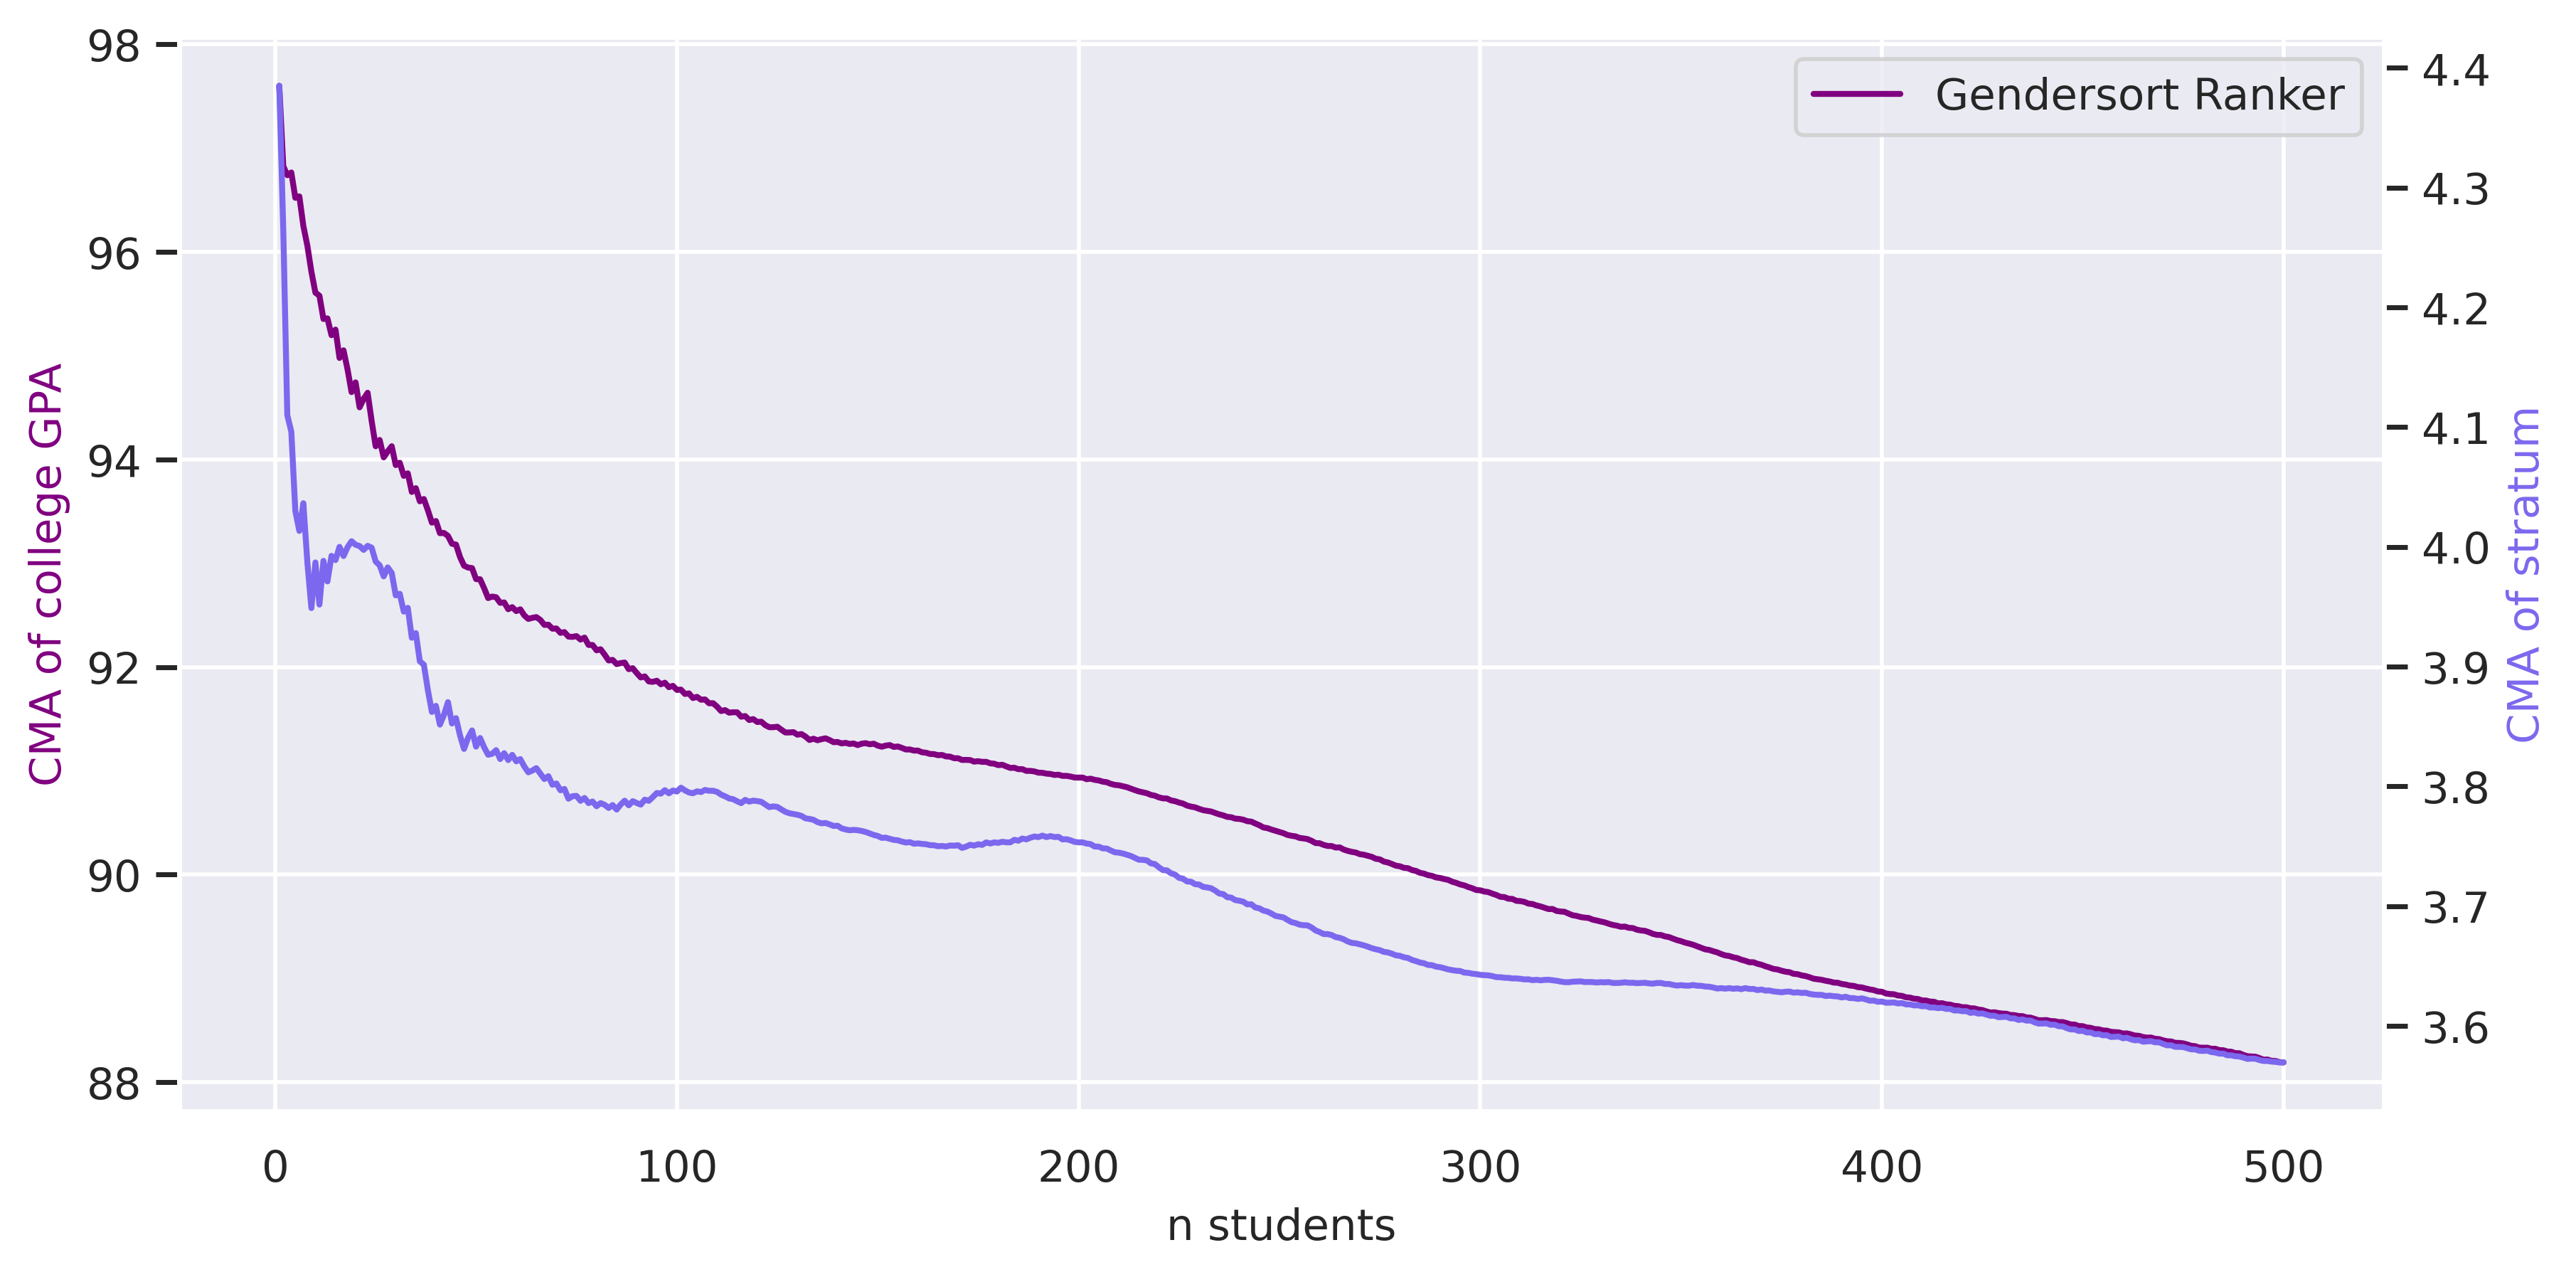

In [18]:
fig,ax = plt.subplots()
# make a plot

ax.plot(gender_df_BIG[:500].n_students, gender_df_BIG[:500].incr_col_mean, color="purple")
# set x-axis label
ax.set_xlabel("n students",fontsize=11)
# set y-axis label
ax.set_ylabel("CMA of college GPA",color="purple",fontsize=11)
ax.legend(["Gendersort Ranker"], loc ="upper right")


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(gender_df_BIG[:500].n_students, gender_df_BIG[:500]["incr_stratum"],color="mediumslateblue")
ax2.set_ylabel("CMA of stratum",color="mediumslateblue",fontsize=11)
ax2.grid(None)
plt.show()


# Random ranker

In [19]:
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})
X_test_y_test_FULL=X_test_y_test_FULL.merge(GUDF_1[['Unnamed: 0','STRATUM','GENDER']], how='left',on='Unnamed: 0',sort=False)

In [20]:
# #Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df_for_Mergesort_single.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin","STRATUM"]] 
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
df_use = df_use.replace({'STRATUM':replaceing})

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)
#The random df to use

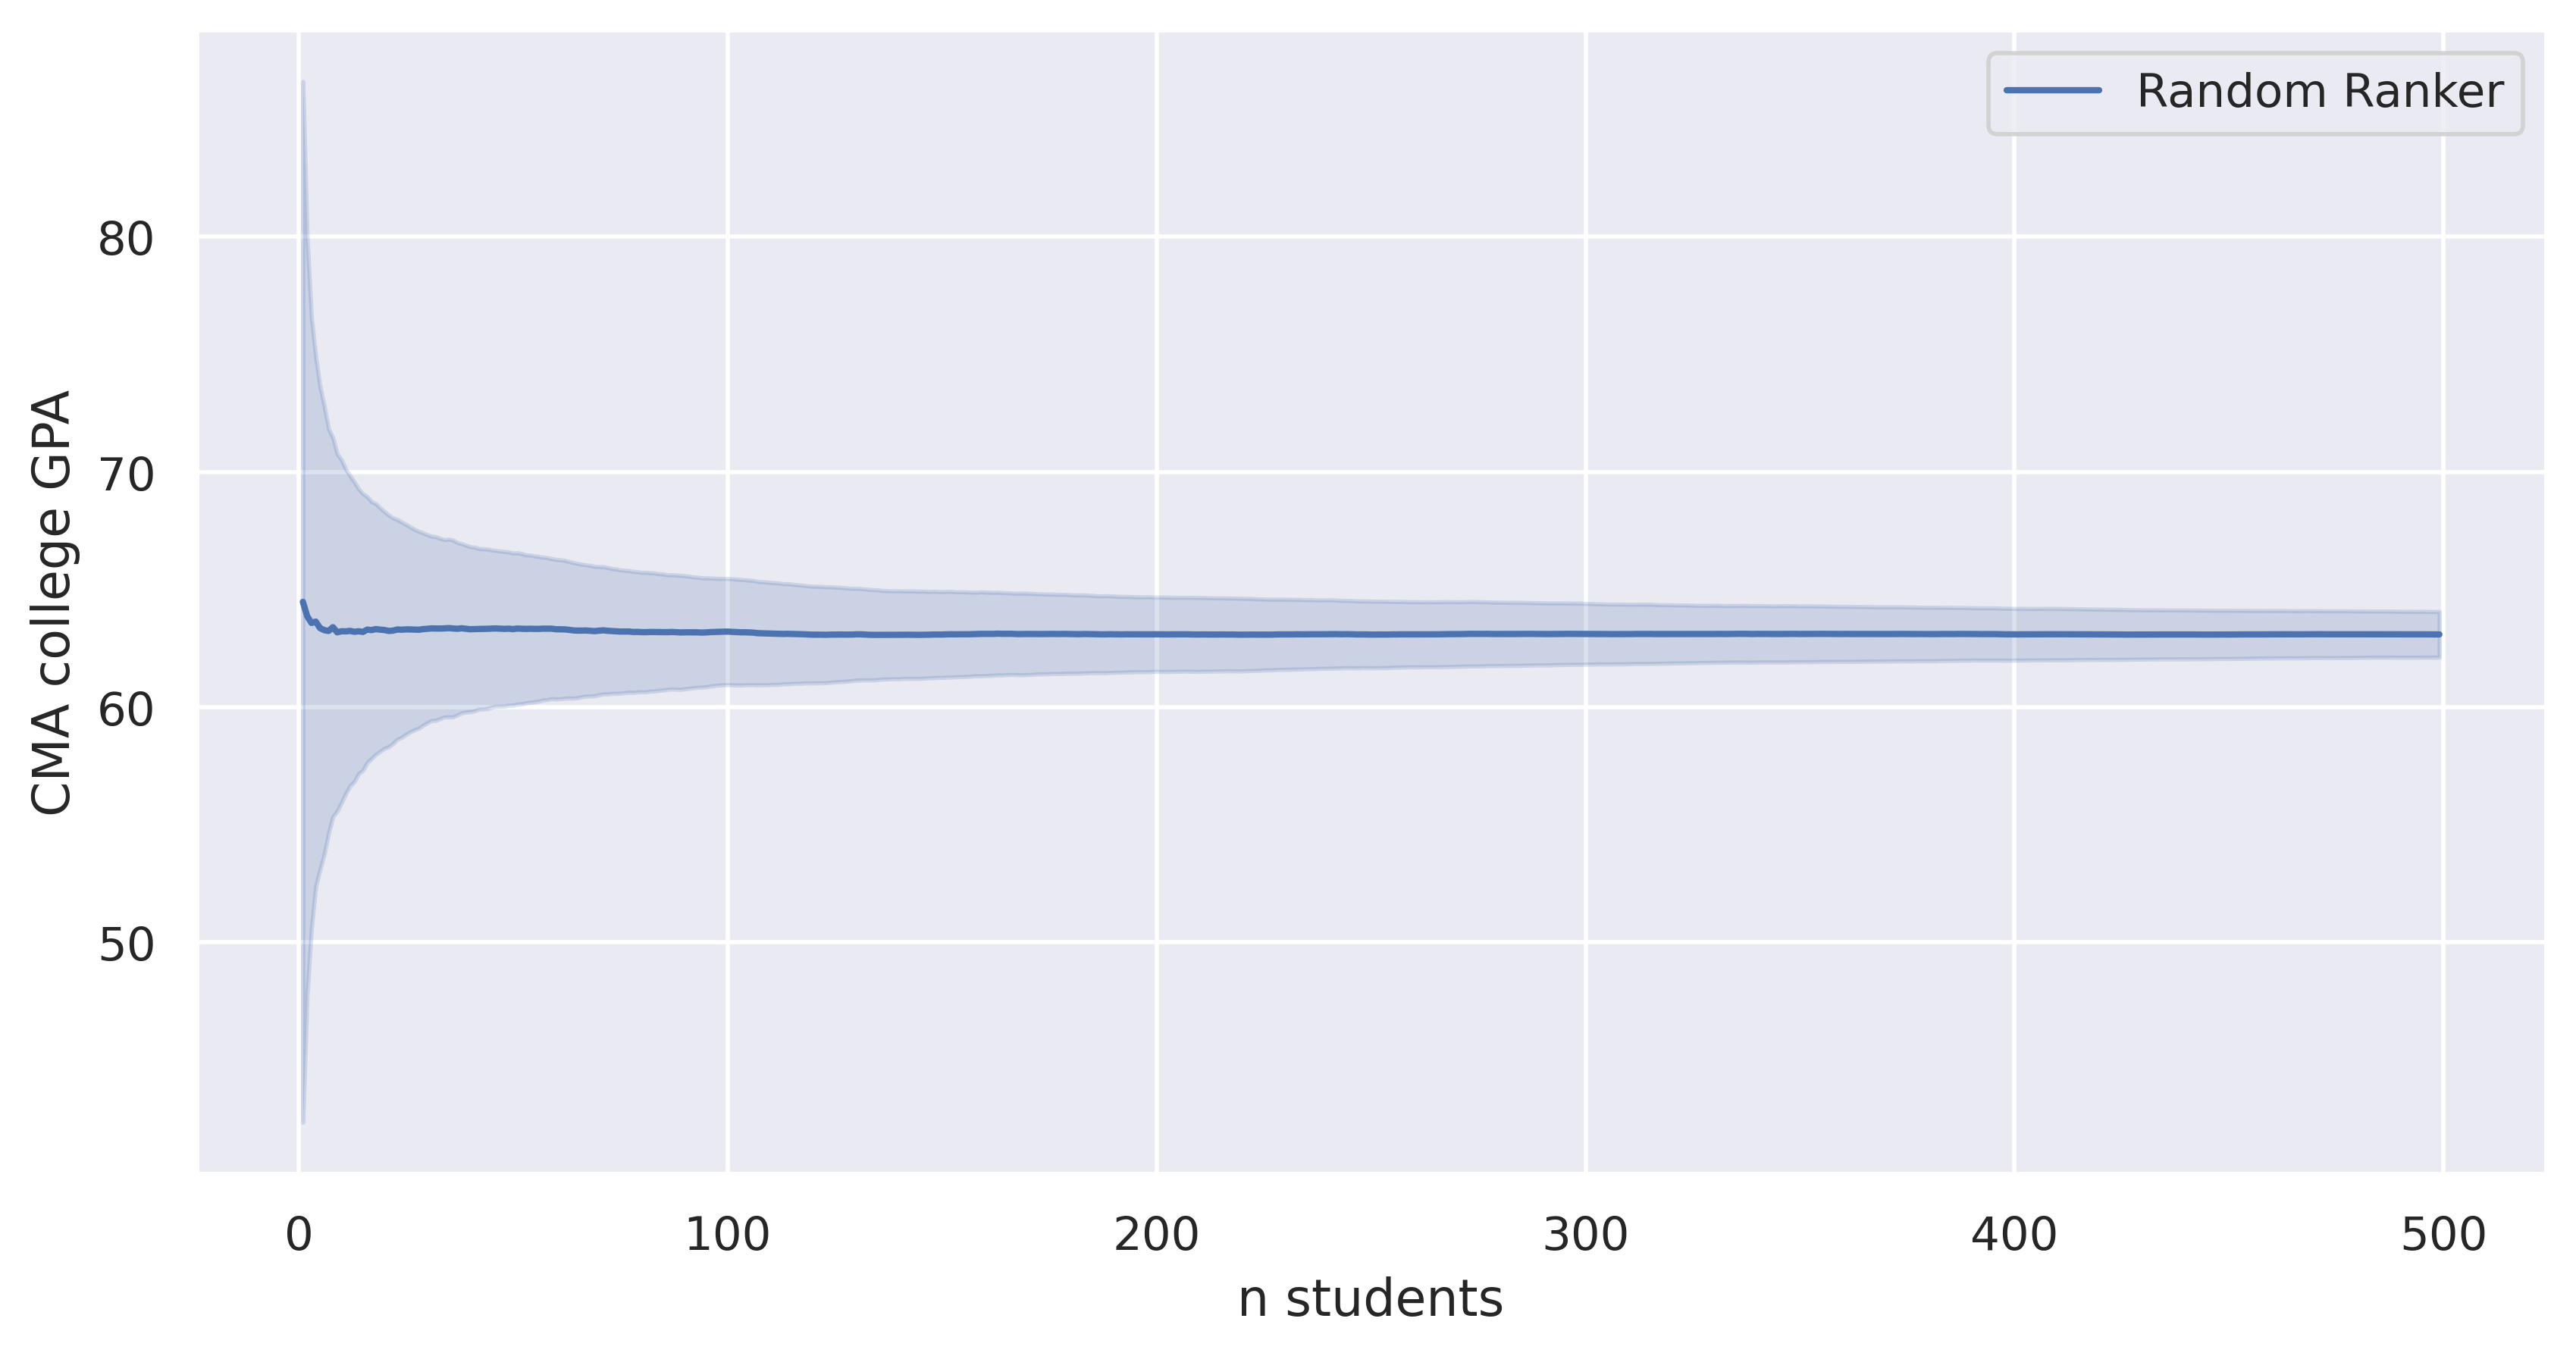

In [21]:
# #only take n students from index 1-500
indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()

indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")
plt.xlabel('n students')
plt.ylabel('CMA college GPA')
plt.legend(["Random Ranker"], loc ="upper right")

# plt.title("Utility - College GPA, Random") 
plt.show()

### The stratum percentages for top-200 rankings

In [22]:
de_første = np.arange(0,200)
df_random_use_første = df_random_use.loc[df_random_use.index.isin(de_første)]
df_random_use_første.STRATUM.value_counts(normalize=True)*100

3    35.919694
2    30.678405
1    14.859917
5     7.680915
4     7.368248
6     3.492821
Name: STRATUM, dtype: float64

# Plain XGBoost 

In [23]:
y_test_TWO = pd.read_csv('TWO_samlet_preds_index_NY_PLAIN.csv')
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

Splitte_PLAIN = np.array_split(y_test_TWO, 200)
GUDF_1['Idx'] = GUDF_1['Unnamed: 0'] 

Merged_PLAIN = pd.DataFrame()
for i in range(200):
    Splitte_PLAIN[i]= Splitte_PLAIN[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_PLAIN[i] = Splitte_PLAIN[i].merge(GUDF_1[['Idx','COL_GRADE_AVG','STRATUM']], on='Idx')
    Splitte_PLAIN[i]= Splitte_PLAIN[i].reset_index()
    Merged_PLAIN = Merged_PLAIN.append(Splitte_PLAIN[i])



### The stratum percentages for top-200 rankings

In [24]:
# How many of each stratum is there 
de_første = np.arange(0,200)
Merged_PLAIN_første = Merged_PLAIN.loc[Merged_PLAIN['Unnamed: 0'].isin(de_første)]
Merged_PLAIN_første.STRATUM.value_counts(normalize=True)*100

3    29.7825
4    27.1050
5    15.5125
2    13.7975
6    11.7975
1     2.0050
Name: STRATUM, dtype: float64

In [25]:

Merged_PLAIN_use_std = Merged_PLAIN.copy()
Merged_PLAIN =  Merged_PLAIN.groupby('index').mean()
Merged_PLAIN_std =  Merged_PLAIN_use_std.groupby('index').std()/np.sqrt(200)


Merged_PLAIN["incr_col_mean"] = Merged_PLAIN['COL_GRADE_AVG'].expanding().mean()
Merged_PLAIN_std["incr_col_mean"] = Merged_PLAIN_std['COL_GRADE_AVG'].expanding().mean()
Merged_PLAIN["incr_stratum"] = Merged_PLAIN['STRATUM'].expanding().mean()

Merged_PLAIN["n_students"] = range(1,len(Merged_PLAIN)+1)



#Adding standard deviation column for "incr_col_mean" and variables for plotting 200
Merged_PLAIN["incr_half_std"] = 0.5*Merged_PLAIN_std["incr_col_mean"] #0.5 of std to plot on both sides of mean
Merged_PLAIN["lower_std"] = Merged_PLAIN["incr_col_mean"] - Merged_PLAIN["incr_half_std"]
Merged_PLAIN["upper_std"] = Merged_PLAIN["incr_col_mean"] + Merged_PLAIN["incr_half_std"]

### Plotting stratum and CMA utility together

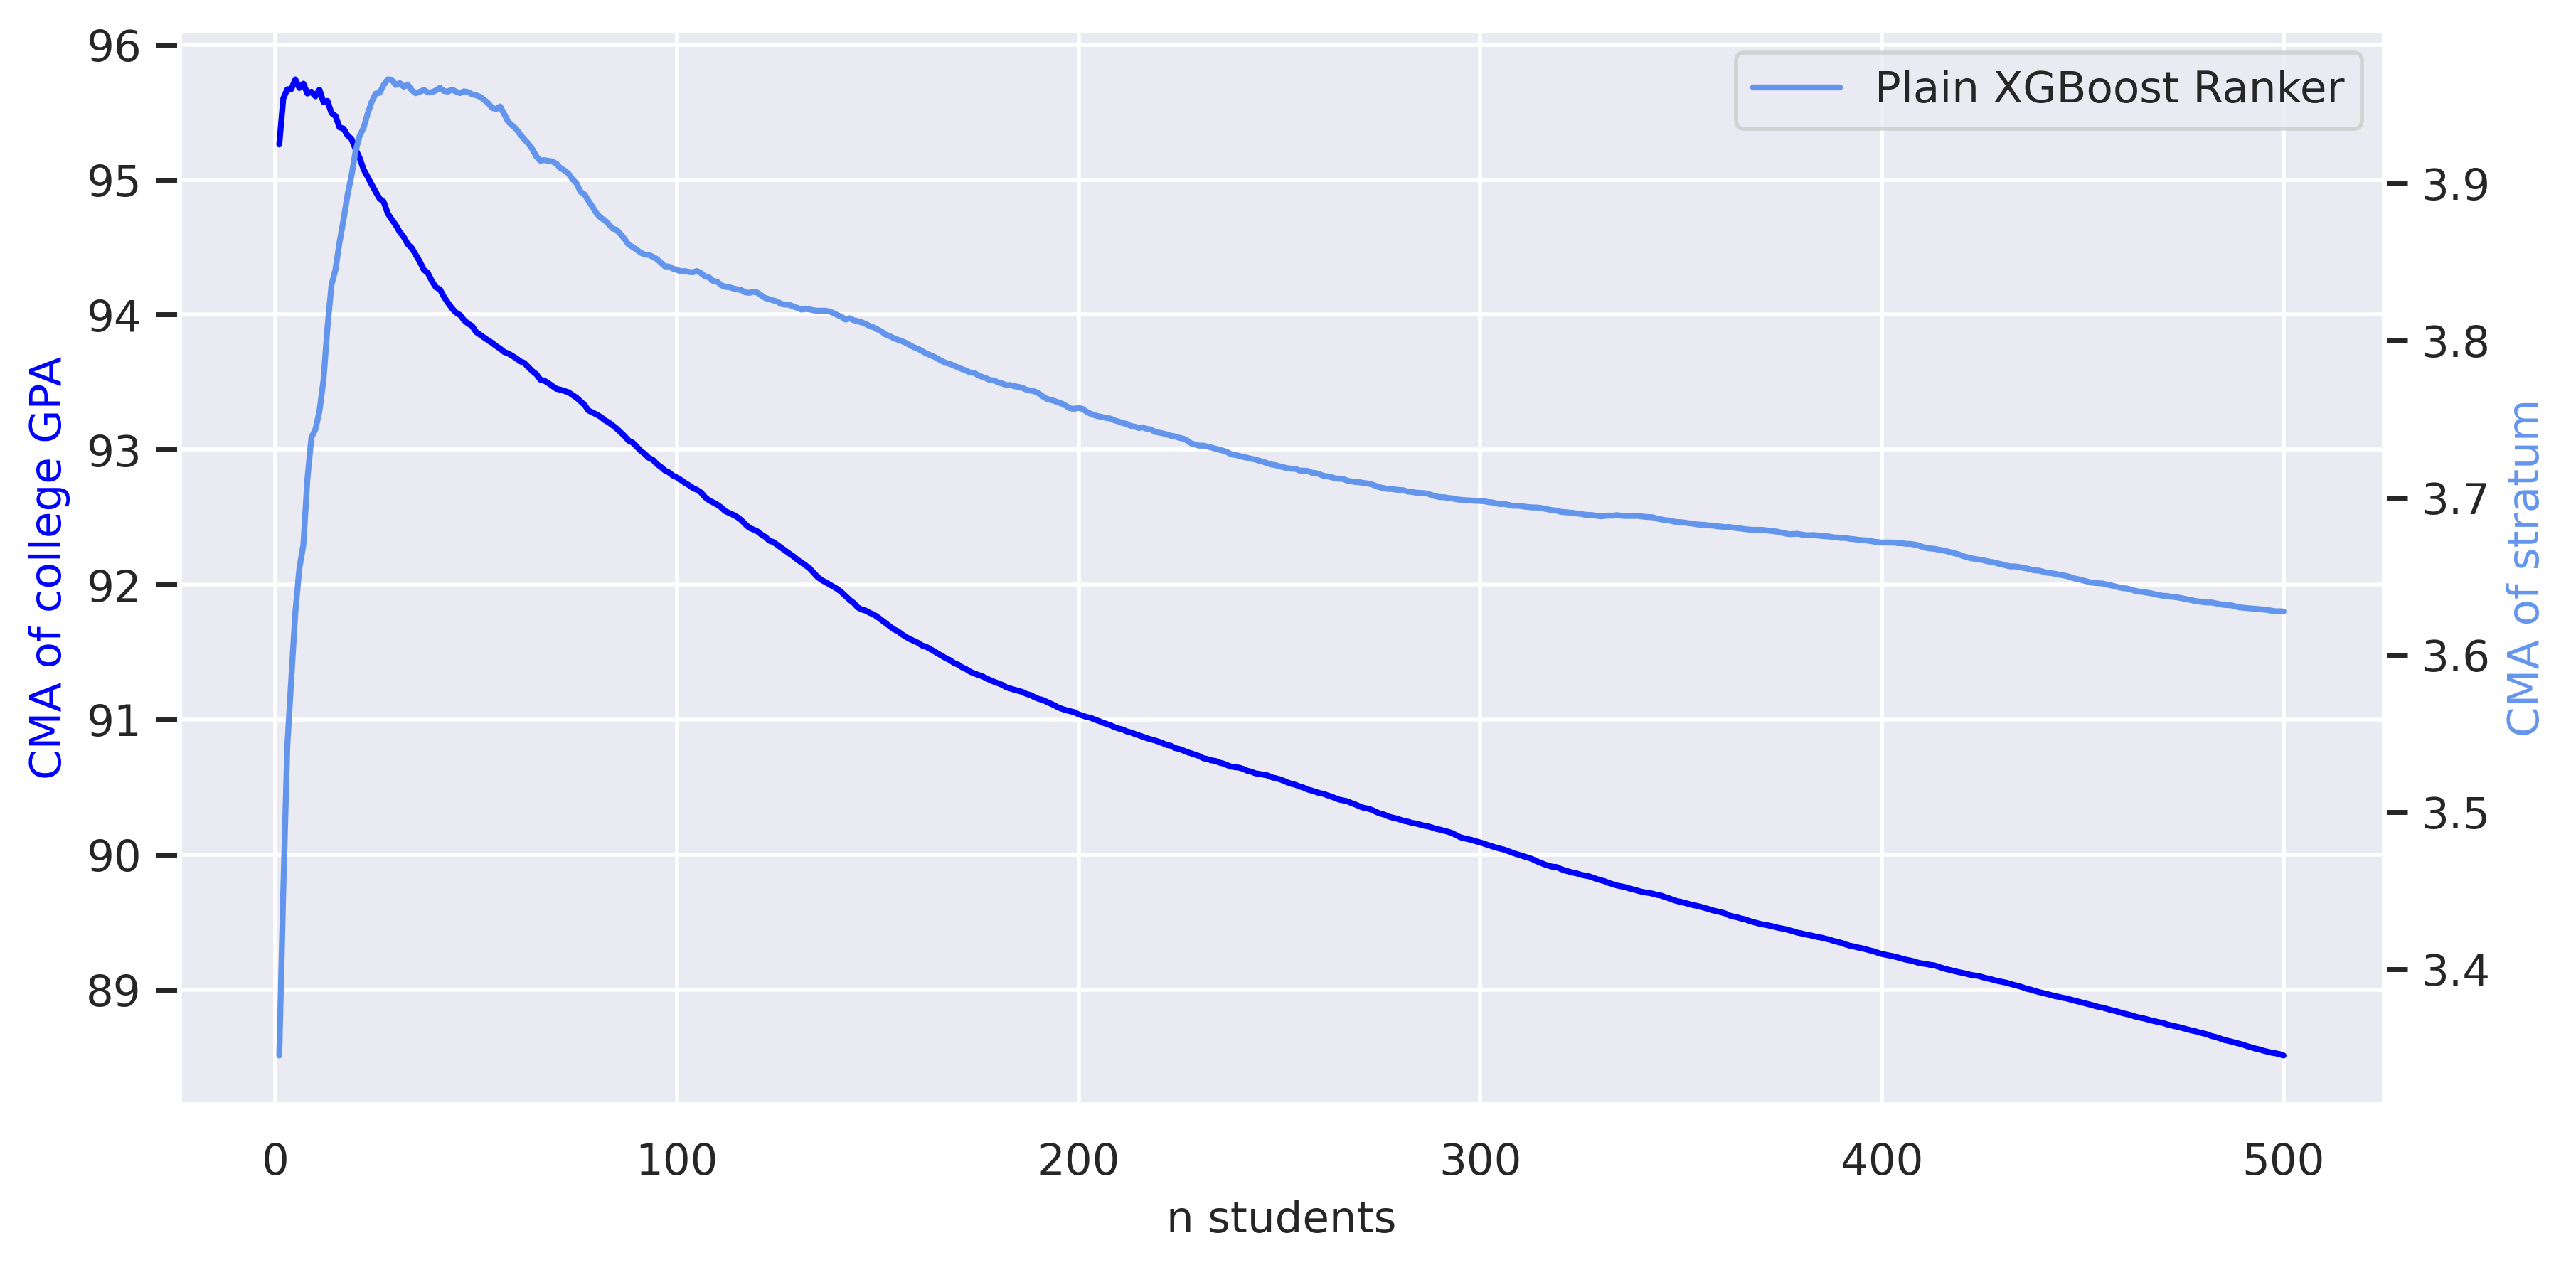

In [26]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot

ax.plot(Merged_PLAIN[:500].n_students, Merged_PLAIN[:500].incr_col_mean, color="blue")
# set x-axis label
ax.set_xlabel("n students",fontsize=11)
# set y-axis label
ax.set_ylabel("CMA of college GPA",color="blue",fontsize=11)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Merged_PLAIN[:500].n_students, Merged_PLAIN[:500]["incr_stratum"],color="cornflowerblue")
ax2.set_ylabel("CMA of stratum",color="cornflowerblue",fontsize=11)
ax2.grid(None)

#plot
plt.xlabel('n students')
plt.ylabel('CMA of stratum')
plt.legend([ "Plain XGBoost Ranker"], loc ="upper right")

plt.show()


# Reduced XGBoost Ranker - Without sensitive attributes

In [27]:
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

y_test_TWO_WO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')

import numpy as np
Splitte_WO = np.array_split(y_test_TWO_WO, 200)
GUDF_1['Idx'] = GUDF_1['Unnamed: 0'] 

Merged_WO = pd.DataFrame()
for i in range(200):
    Splitte_WO[i]= Splitte_WO[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_WO[i] = Splitte_WO[i].merge(GUDF_1[['Idx','COL_GRADE_AVG', 'STRATUM']], on='Idx')
    Splitte_WO[i]= Splitte_WO[i].reset_index()
    Merged_WO = Merged_WO.append(Splitte_WO[i])

### The stratum percentages for top-200 rankings

In [28]:
# How many of each stratum is there 
de_første = np.arange(0,200)
Merged_WO_første = Merged_WO.loc[Merged_WO['Unnamed: 0'].isin(de_første)]
Merged_WO_første.STRATUM.value_counts(normalize=True)*100

3    29.9575
4    24.4300
5    15.2450
2    14.2975
6    13.2450
1     2.8250
Name: STRATUM, dtype: float64

In [29]:
# Standard errors 
Merged_WO_use_std = Merged_WO.copy()
Merged_WO =  Merged_WO.groupby('index').mean()
Merged_WO_std =  Merged_WO_use_std.groupby('index').std()/np.sqrt(200)

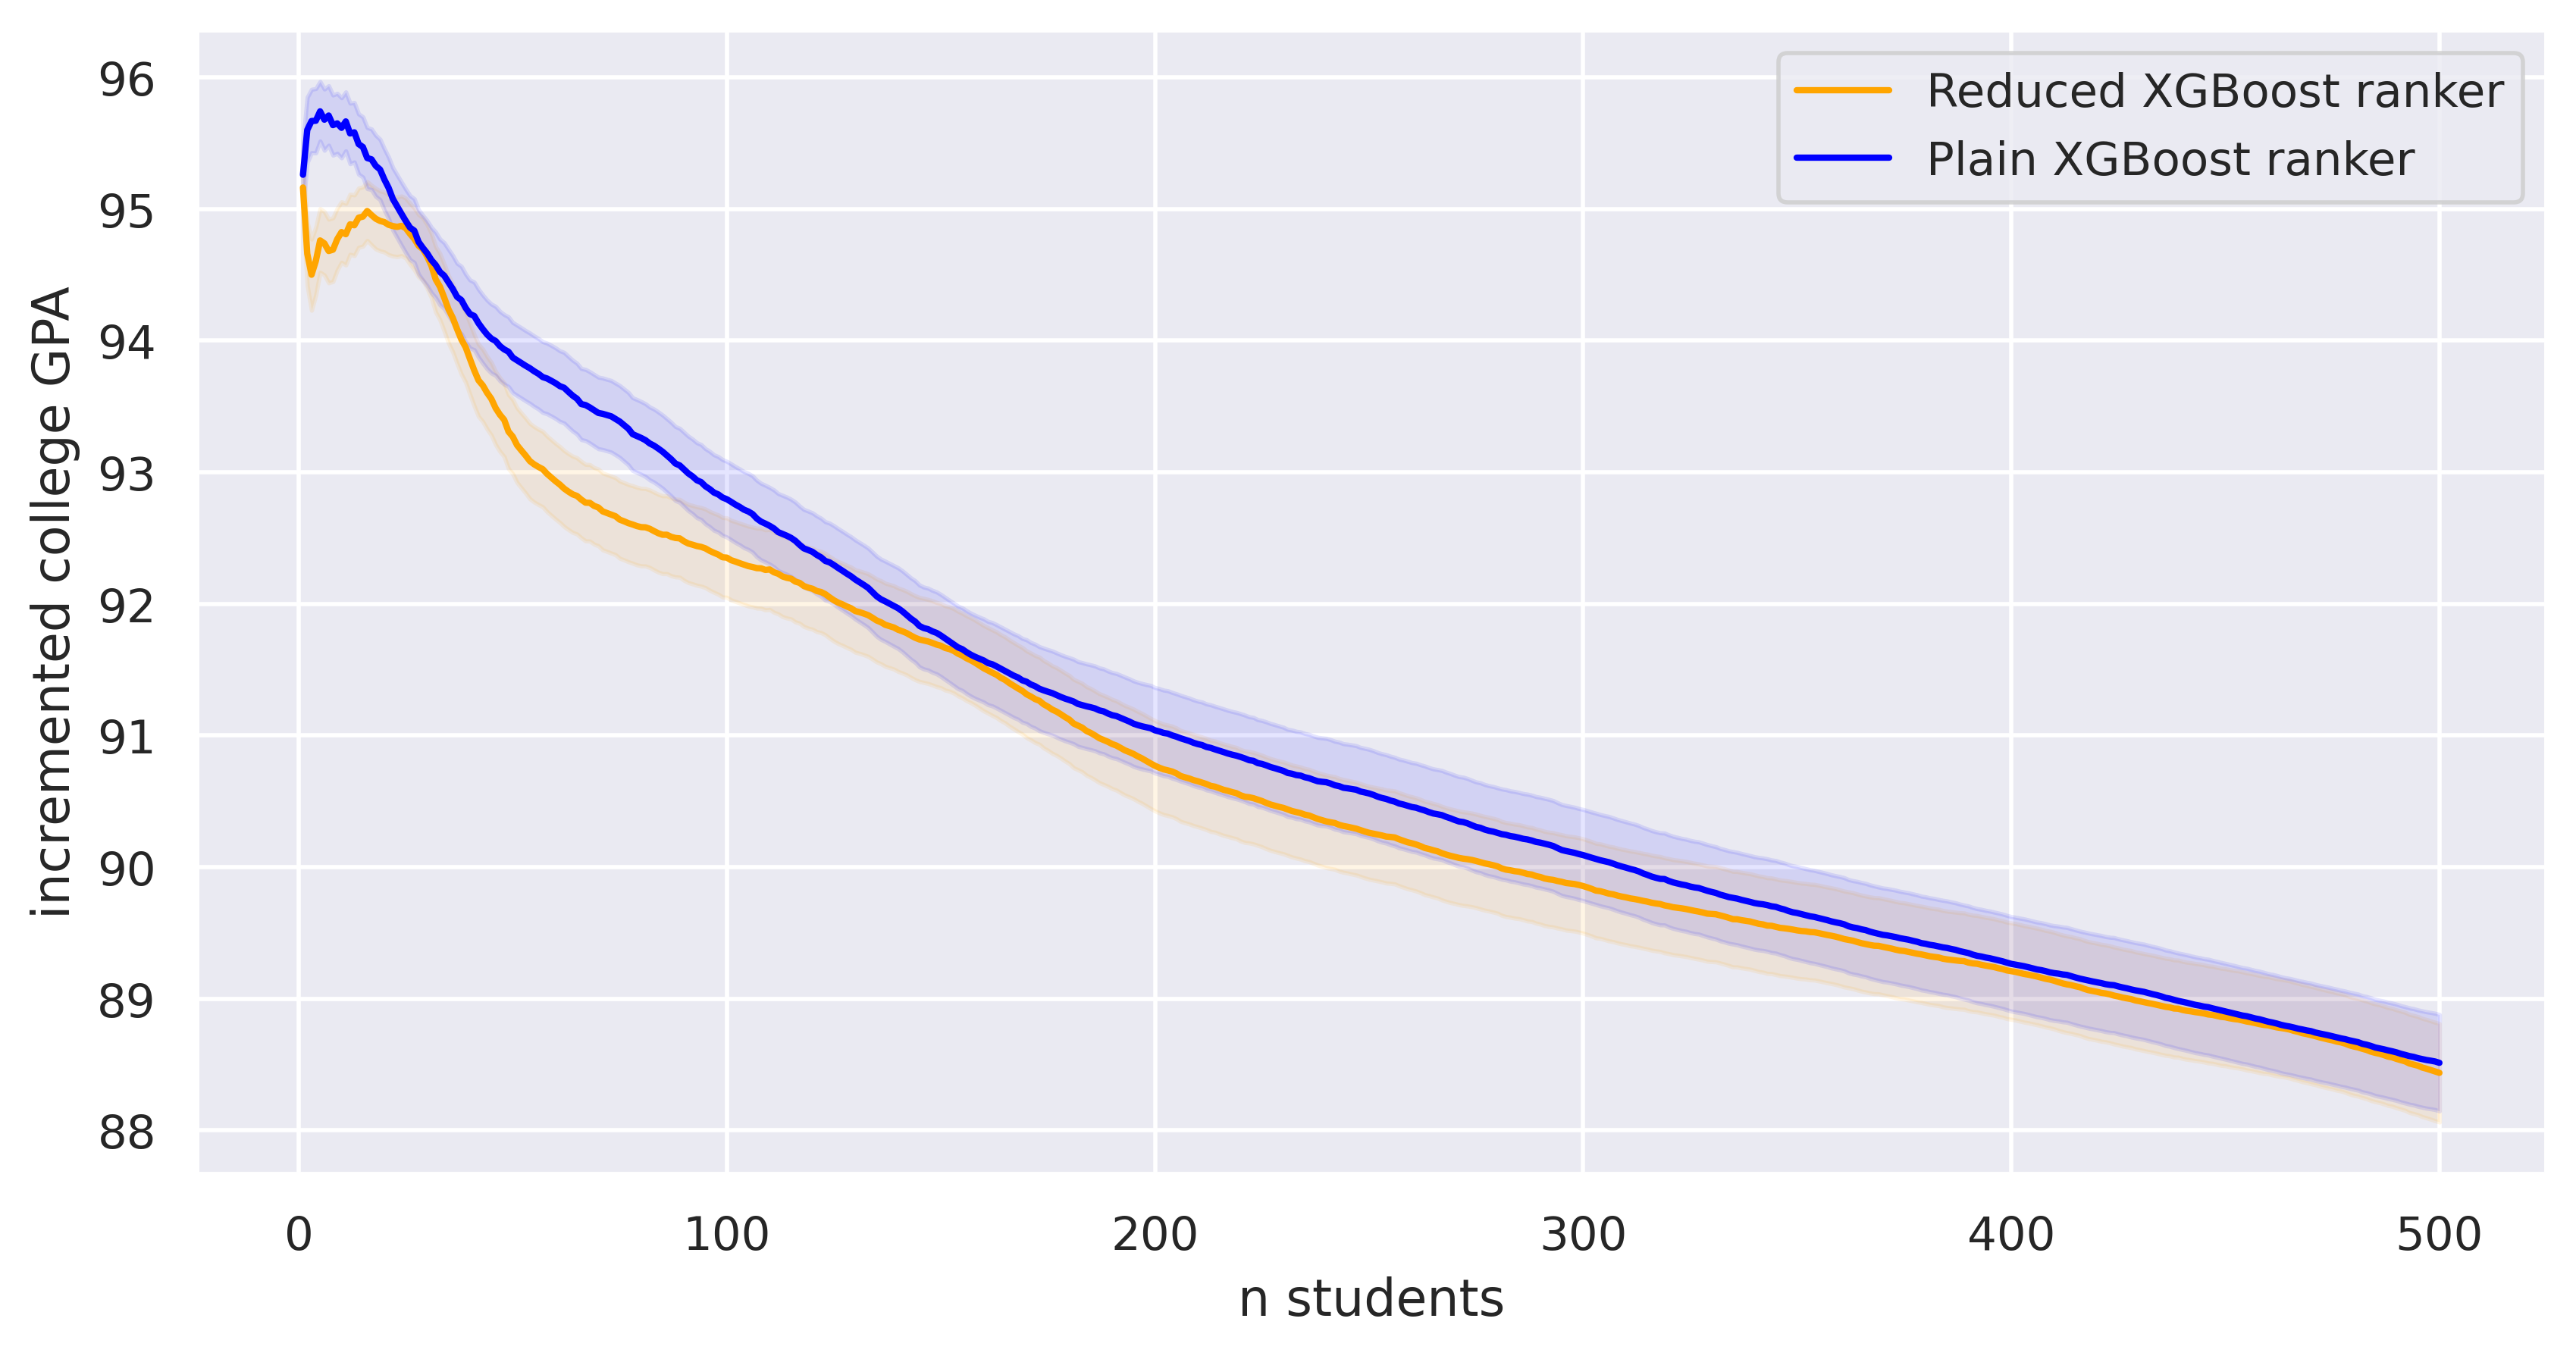

In [30]:
# add exp. mean
# Merged_WO = Merged_WO.sort_values('Preds',ascending=False)
Merged_WO["incr_col_mean"] = Merged_WO['COL_GRADE_AVG'].expanding().mean()
Merged_WO["incr_stratum"] = Merged_WO['STRATUM'].expanding().mean()
Merged_WO_std["incr_col_mean"] = Merged_WO_std['COL_GRADE_AVG'].expanding().mean()

Merged_WO["n_students"] = range(1,len(Merged_WO)+1)



#add exp. std
Merged_WO["incr_half_std"] = 0.5*Merged_WO_std["incr_col_mean"] #0.5 of std to plot on both sides of mean
Merged_WO["lower_std"] = Merged_WO["incr_col_mean"] - Merged_WO["incr_half_std"]
Merged_WO["upper_std"] = Merged_WO["incr_col_mean"] + Merged_WO["incr_half_std"]



#plot Plain and WO
plt.xlabel('n students')
plt.ylabel('incremented college GPA')


sns.lineplot(data=Merged_WO[:500], x="n_students", y="incr_col_mean",  color="orange")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_WO[:500], alpha=0.1, color="orange")

sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="blue")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[:500], alpha=0.1, color="blue")
plt.legend(["Reduced XGBoost ranker", 'Plain XGBoost ranker'], loc ="upper right")



plt.show()

### Plotting average stratum and CMA utility together

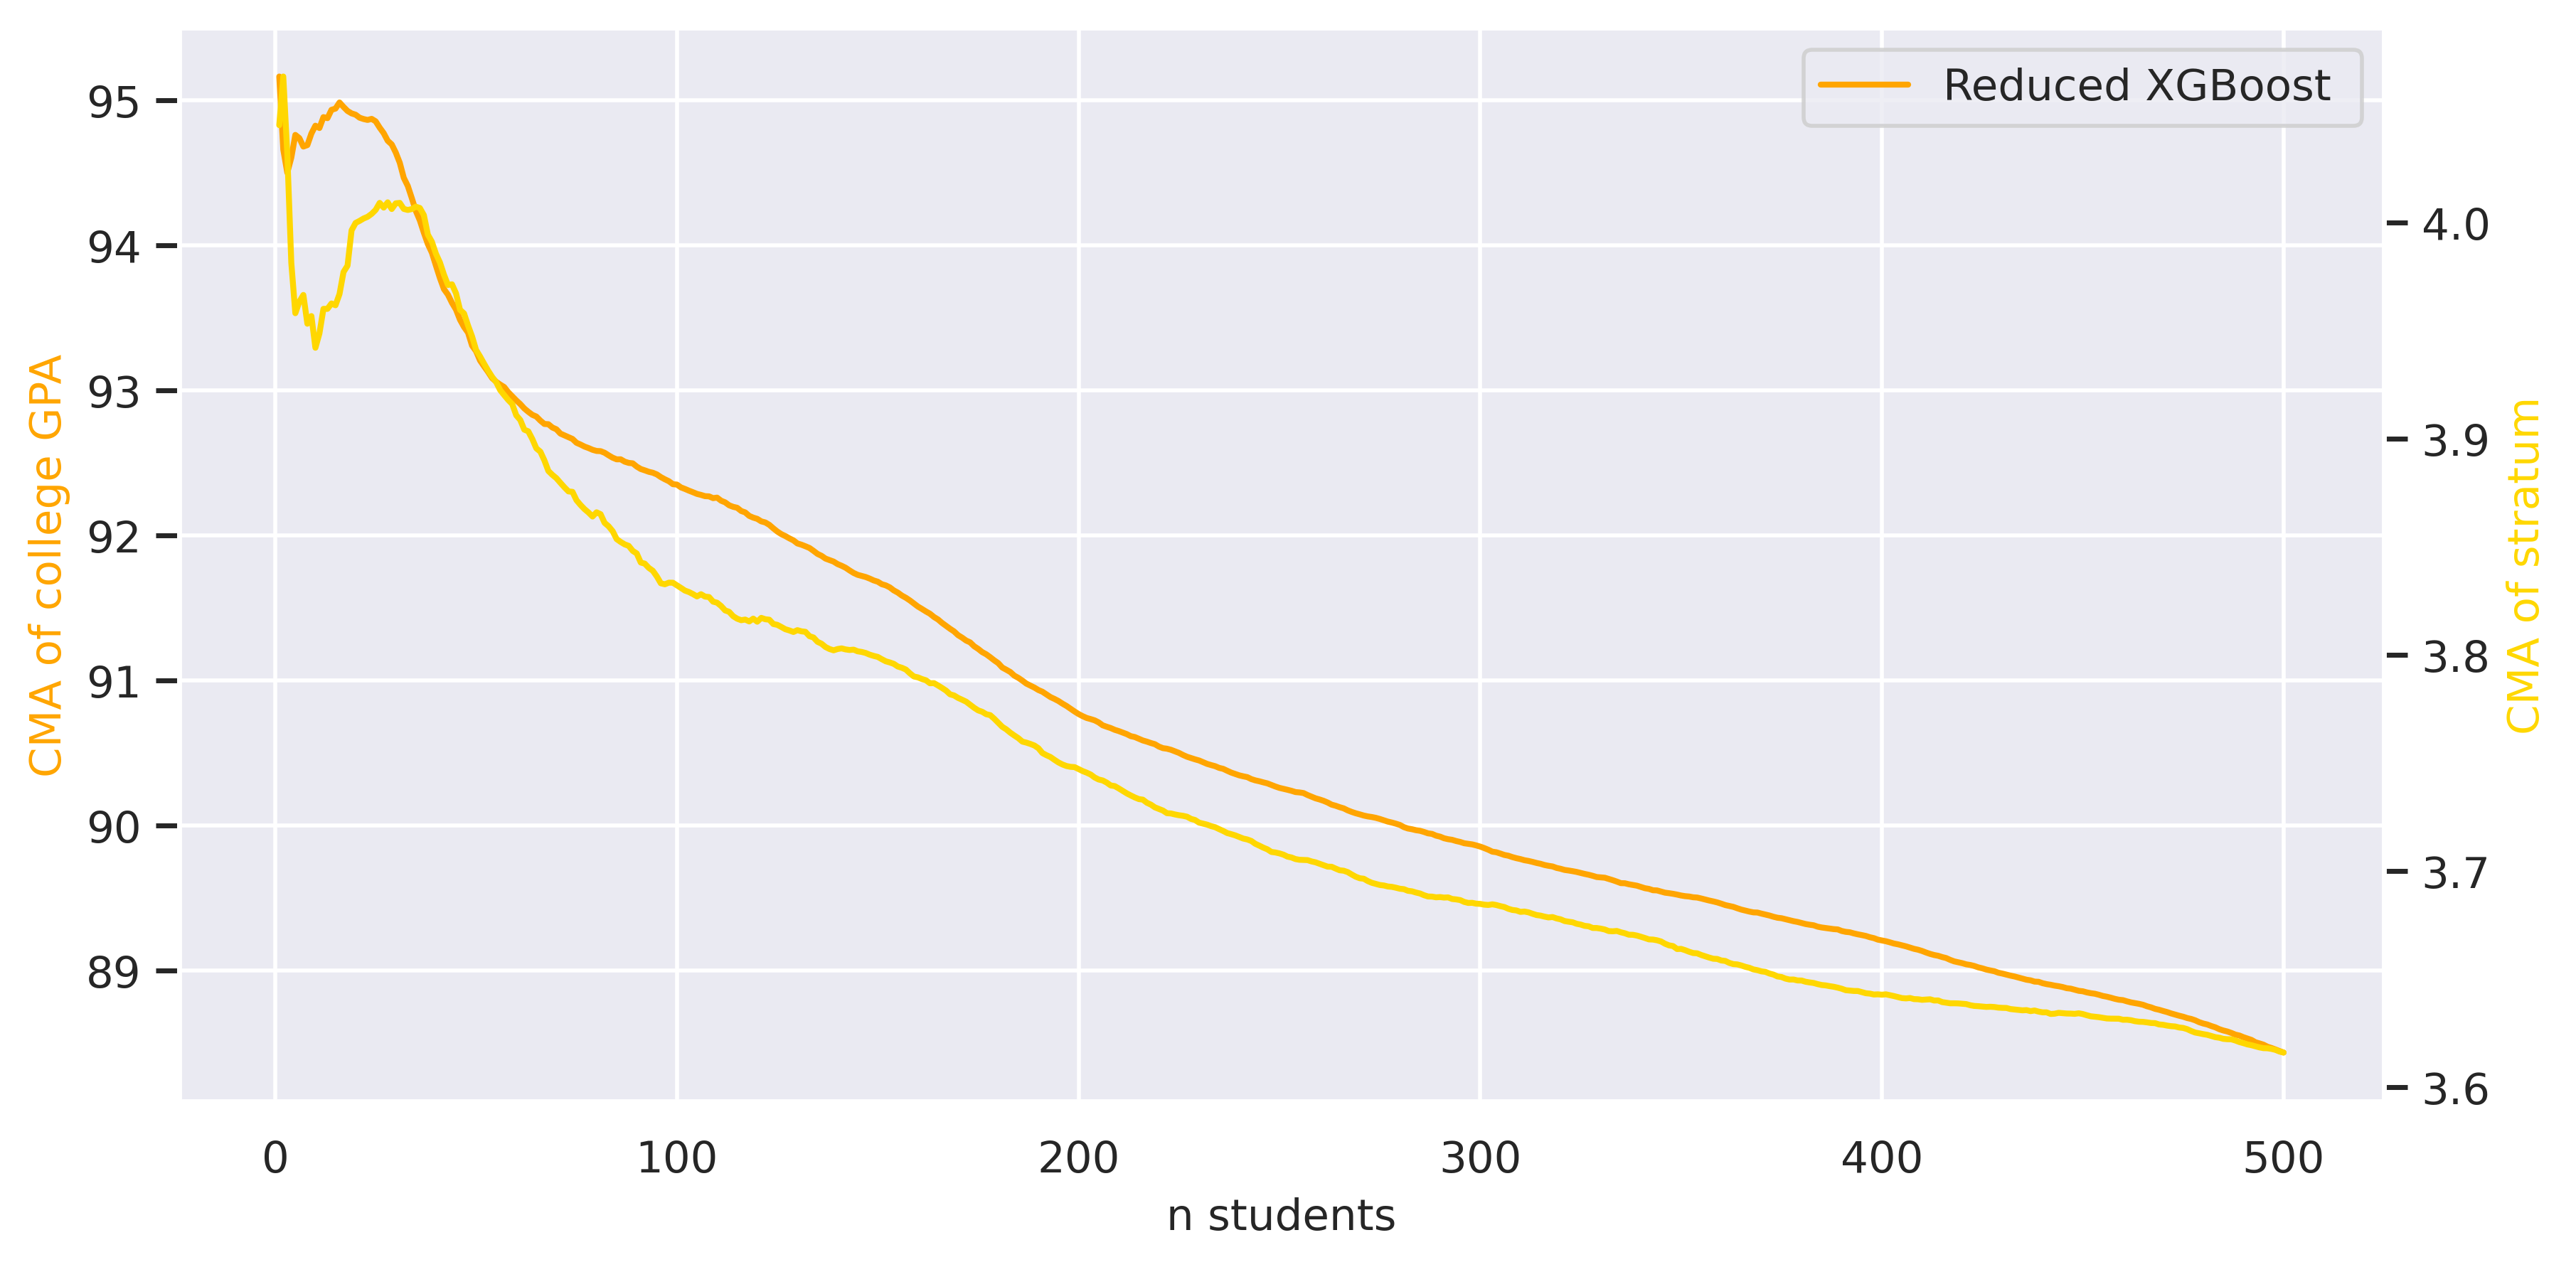

In [31]:
fig,ax = plt.subplots()
# make a plot

ax.plot(Merged_WO[:500].n_students, Merged_WO[:500].incr_col_mean, color="orange")
# set x-axis label
ax.set_xlabel("n students",fontsize=11)
# set y-axis label
ax.set_ylabel("CMA of college GPA",color="orange",fontsize=11)

plt.legend([ "Reduced XGBoost "], loc ="upper right")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Merged_WO[:500].n_students, Merged_WO[:500]["incr_stratum"],color="gold")
ax2.set_ylabel("CMA of stratum",color="gold",fontsize=11)
ax2.grid(None)


plt.xlabel('n students')
plt.ylabel('CMA of stratum')

plt.show()


# Fairness enhanced Ranker - 200 re-rankings

In [32]:
df_fair_TWO = pd.read_csv('re_ranked_199_NY_50.csv') # denne er på 5 procent
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

import numpy as np
Splitte_FAIR = np.array_split(df_fair_TWO, 200)
GUDF_1['Idx'] = GUDF_1['Unnamed: 0'] 

Merged_FAIR = pd.DataFrame()
for i in range(200):
    Splitte_FAIR[i]= Splitte_FAIR[i].sort_values(by="Preds", ascending=False, kind="mergesort")
    Splitte_FAIR[i] = Splitte_FAIR[i].merge(GUDF_1[['Idx','COL_GRADE_AVG','STRATUM']], on='Idx')
    Splitte_FAIR[i]= Splitte_FAIR[i].reset_index()
    Merged_FAIR = Merged_FAIR.append(Splitte_FAIR[i])


### The stratum percentages for top-200 rankings

In [33]:
de_første = np.arange(0,200)
Merged_FAIR_første = Merged_FAIR.loc[Merged_FAIR['Unnamed: 0'].isin(de_første)]
Merged_FAIR_første.STRATUM.value_counts(normalize=True)*100

3    30.0300
4    27.3600
5    15.4425
2    13.5400
6    11.5625
1     2.0650
Name: STRATUM, dtype: float64

In [34]:
Merged_FAIR_use_std = Merged_FAIR.copy()
Merged_FAIR =  Merged_FAIR.groupby('index').mean()
Merged_FAIR_std =  Merged_FAIR_use_std.groupby('index').std()/np.sqrt(200)

Merged_FAIR["incr_col_mean"] = Merged_FAIR['COL_GRADE_AVG'].expanding().mean()
Merged_FAIR_std["incr_col_error"] = Merged_FAIR_std['COL_GRADE_AVG'].expanding().mean()
Merged_FAIR["incr_stratum"] = Merged_FAIR['STRATUM'].expanding().mean()

Merged_FAIR["n_students"] = range(1,len(Merged_FAIR)+1)


Merged_FAIR["incr_half_std"] = 0.5*Merged_FAIR_std["incr_col_error"] #0.5 of std to plot on both sides of mean
Merged_FAIR["lower_std"] = Merged_FAIR["incr_col_mean"] - Merged_FAIR["incr_half_std"]
Merged_FAIR["upper_std"] = Merged_FAIR["incr_col_mean"] + Merged_FAIR["incr_half_std"]




# plt.xlabel('n students')
# plt.ylabel('CMA college GPA')
# # plt.title('Utility of Plain XGBoost - College GPA, predictions and actual grades')
# plt.legend(["Plain XGBoost predictions", 'Plain XGBoost actual college GPAs'], loc ="upper right")



# sns.lineplot(data=Merged_WO[:500], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
# sns.lineplot(data=Merged_PLAIN[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
# sns.lineplot(data=Merged_FAIR[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd")



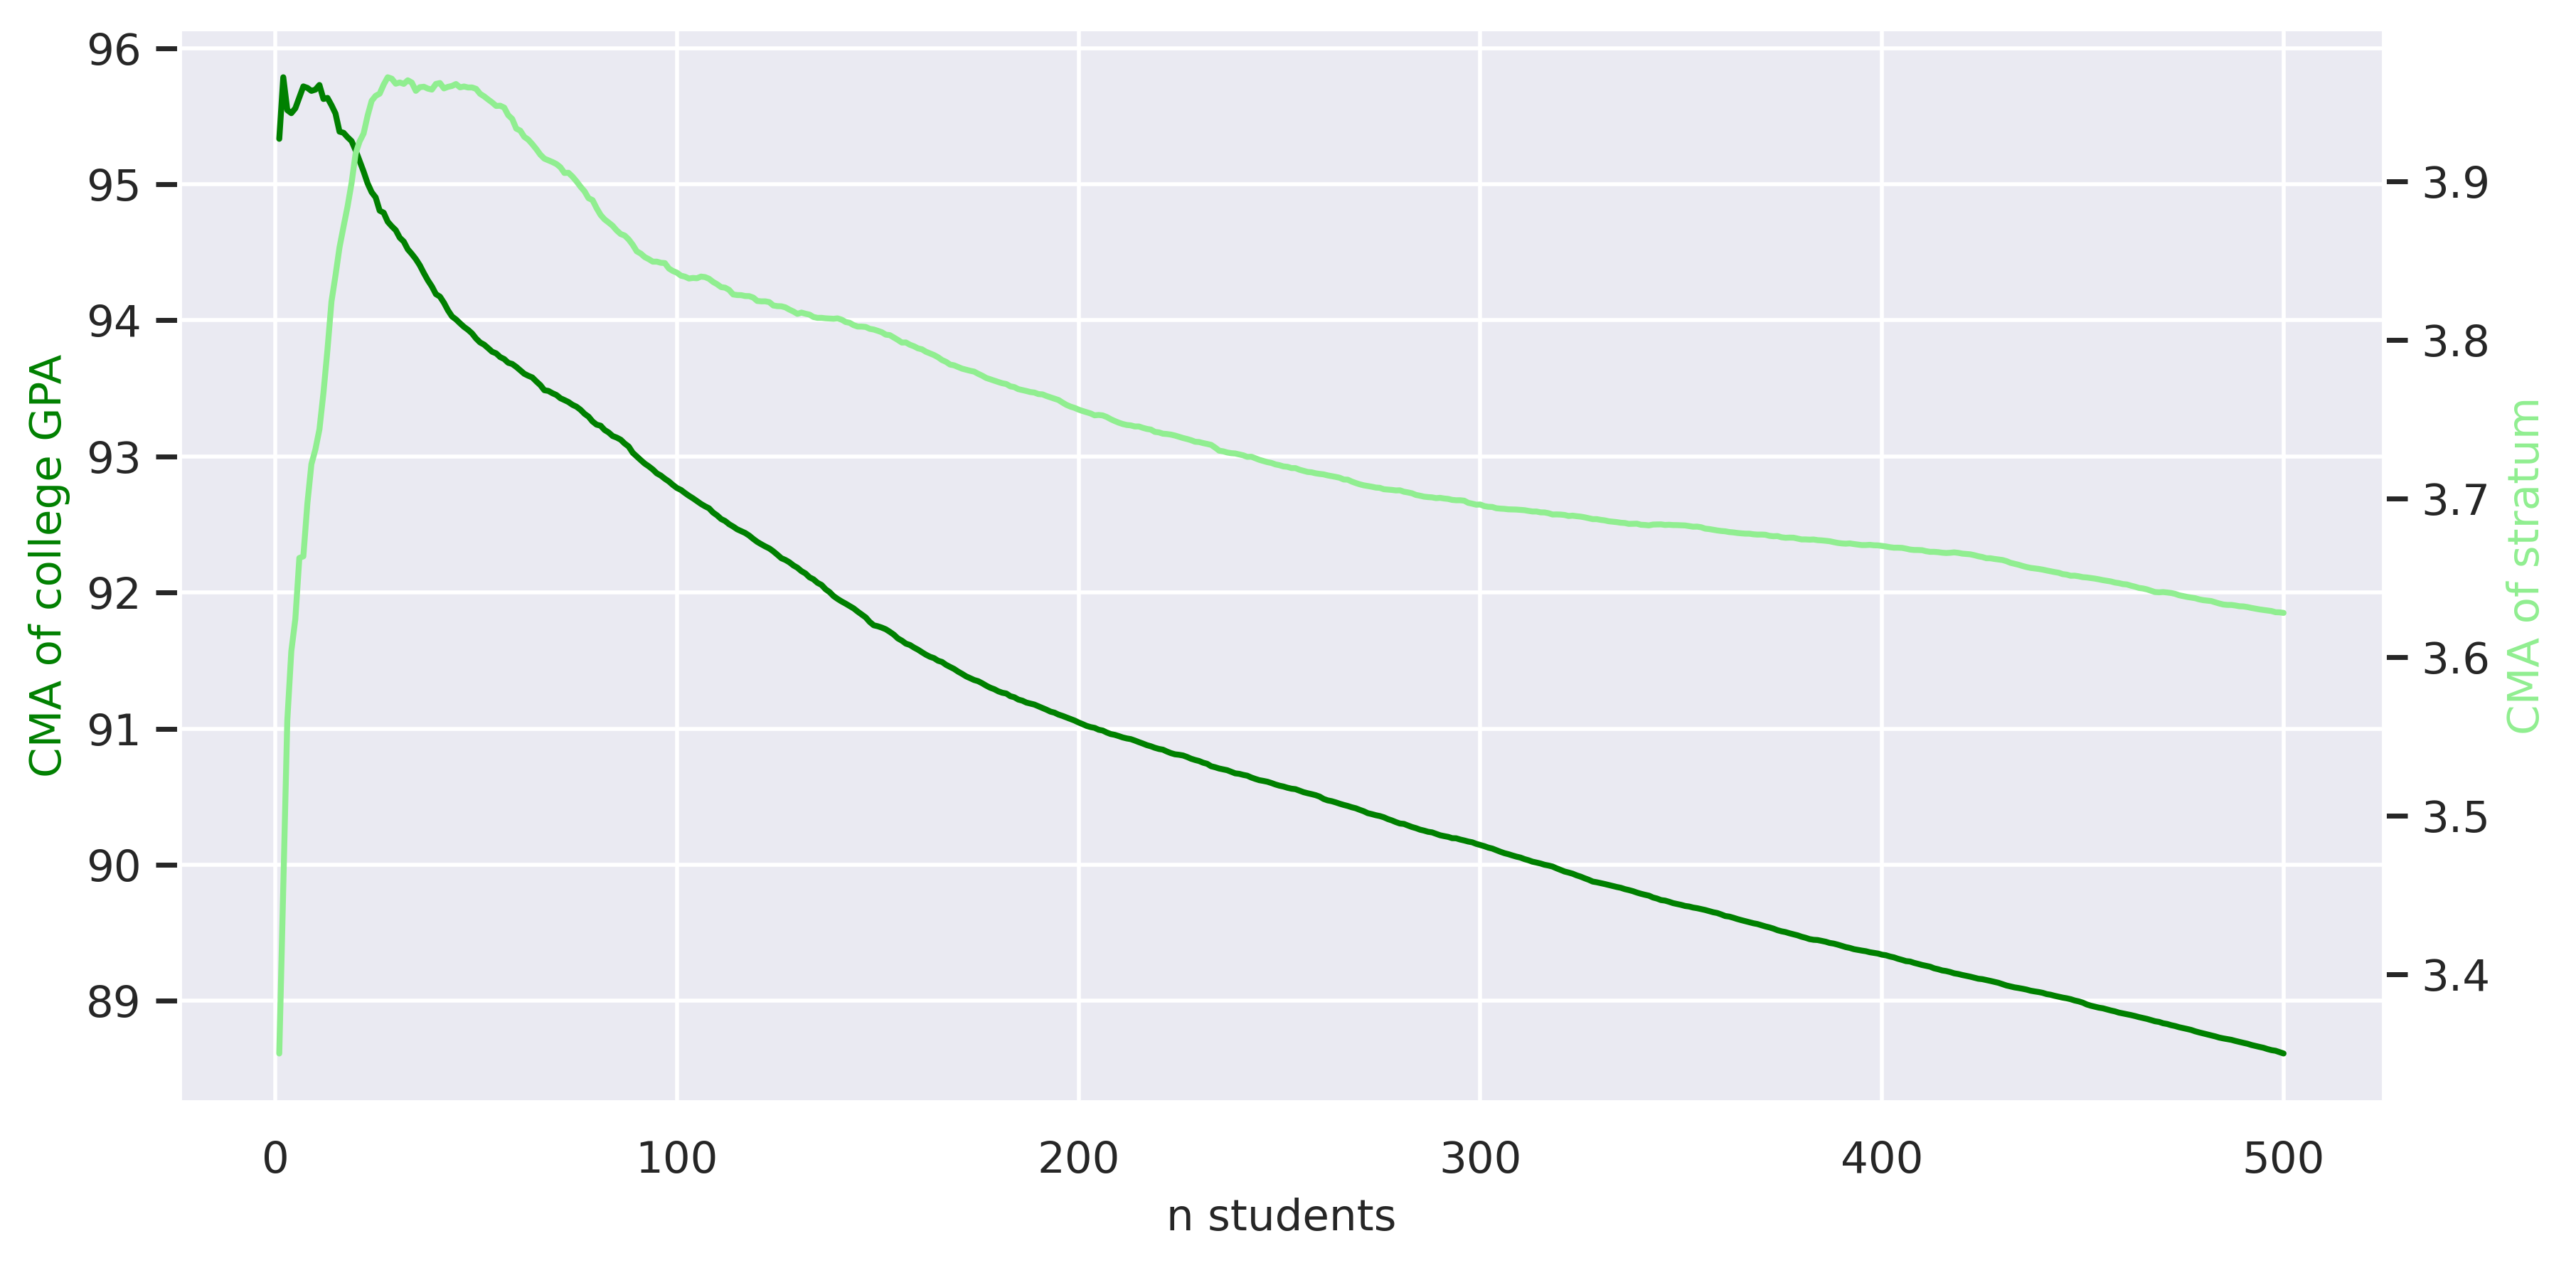

In [35]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot

ax.plot(Merged_FAIR[:500].n_students, Merged_FAIR[:500].incr_col_mean, color="green")
# set x-axis label
ax.set_xlabel("n students",fontsize=11)
# set y-axis label
ax.set_ylabel("CMA of college GPA",color="green",fontsize=11)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Merged_FAIR[:500].n_students, Merged_FAIR[:500]["incr_stratum"],color="lightgreen")
ax2.set_ylabel("CMA of stratum",color="lightgreen",fontsize=11)
ax2.grid(None)

plt.show()


# Ground truth inspection

In [36]:
GUDF = pd.read_csv('GUDF.csv')
GUDF_1 = GUDF.copy()
replaceing = {'Stratum_1':1, 'Stratum_2':2, 'Stratum_3':3,'Stratum_4':4, 'Stratum_5':5, 'Stratum_6':6, '0':0}
GUDF_1 = GUDF_1.replace({'STRATUM':replaceing})

In [37]:
GT = pd.read_csv('GT.csv')
GT_copy = GT.copy()
GUDF_1['STRATUM']
GT_copy = GT_copy.merge(GUDF_1, on='Unnamed: 0')
GT_copy[:500]

Unnamed: 0  rank_y_test      y_test  rank_preds      preds GENDER  \
0         12328            0  100.000000           0  93.462350      M   
1          5132            1   99.666667         196  88.442360      F   
2          6305            2   99.666667         438  85.841780      M   
3          8883            3   99.666667          90  90.205180      M   
4           258            4   99.666667         101  90.126290      M   
..          ...          ...         ...         ...        ...    ...   
495        6846          495   90.000000        1356  73.244995      M   
496        9388          496   90.000000         295  86.544980      M   
497       11383          497   90.000000         389  85.841780      M   
498        5027          498   90.000000          20  93.462350      M   
499        5041          499   89.666667         600  82.636680      F   

     STRATUM SCHOOL_NAT         SCHOOL_TYPE  MAT_S11  CR_S11  CC_S11  BIO_S11  \
0          3    PRIVATE            ACADEMIC      100     100      80       95   
1          3    PRIVATE            ACADEMIC       70      77      65       69   
2          2     PUBLIC  TECHNICAL/ACADEMIC       77      75      64      100   
3          3    PRIVATE            ACADEMIC       82      73      76       88   
4          4    PRIVATE            ACADEMIC       86      85      72       81   
..       ...        ...                 ...      ...     ...     ...      ...   
495        3     PUBLIC  TECHNICAL/ACADEMIC       74      62      62       68   
496        4    PRIVATE            ACADEMIC       77      75      77       74   
497        6    PRIVATE            ACADEMIC       76      68      69       93   
498        4    PRIVATE            ACADEMIC       74      87      82       74   
499        4    PRIVATE  TECHNICAL/ACADEMIC       67      64      60       65   

     ENG_S11  QR_PRO  CR_PRO  CC_PRO  ENG_PRO  WC_PRO  COL_GRADE_AVG  \
0        100      99     100     100      100      99     100.000000   
1         90      99      99     100      100      99      99.666667   
2         85     100     100      99      100      88      99.666667   
3         96      99     100      99      100      63      99.666667   
4         90     100      99     100      100      41      99.666667   
..       ...     ...     ...     ...      ...     ...            ...   
495       74      97      87      89       94      78      90.000000   
496       76      93      84      96       90      99      90.000000   
497       90     100      99      71      100      82      90.000000   
498       95      91      99      71      100      94      90.000000   
499       95      96      89      85       95      55      89.666667   

     HI_GRADE_AVG  GENDER_bin  
0       93.333333           0  
1       77.333333           1  
2       74.666667           0  
3       81.666667           0  
4       82.333333           0  
..            ...         ...  
495     66.000000           0  
496     76.000000           0  
497     75.666667           0  
498     88.000000           0  
499     73.000000           1  

[500 rows x 22 columns]

### STratum percentage og one train-test split

In [38]:
GUDF_sorted = GUDF_1.sort_values(by='COL_GRADE_AVG')

In [39]:
de_første = np.arange(0,200)
GT_copy_stra = GT_copy.loc[GT_copy['Unnamed: 0'].isin(de_første)]
GT_copy_stra.STRATUM.value_counts(normalize=True)*100

3    37.931034
4    17.241379
2    15.517241
6    12.068966
5    10.344828
1     6.896552
Name: STRATUM, dtype: float64

# All utilities (with CI)

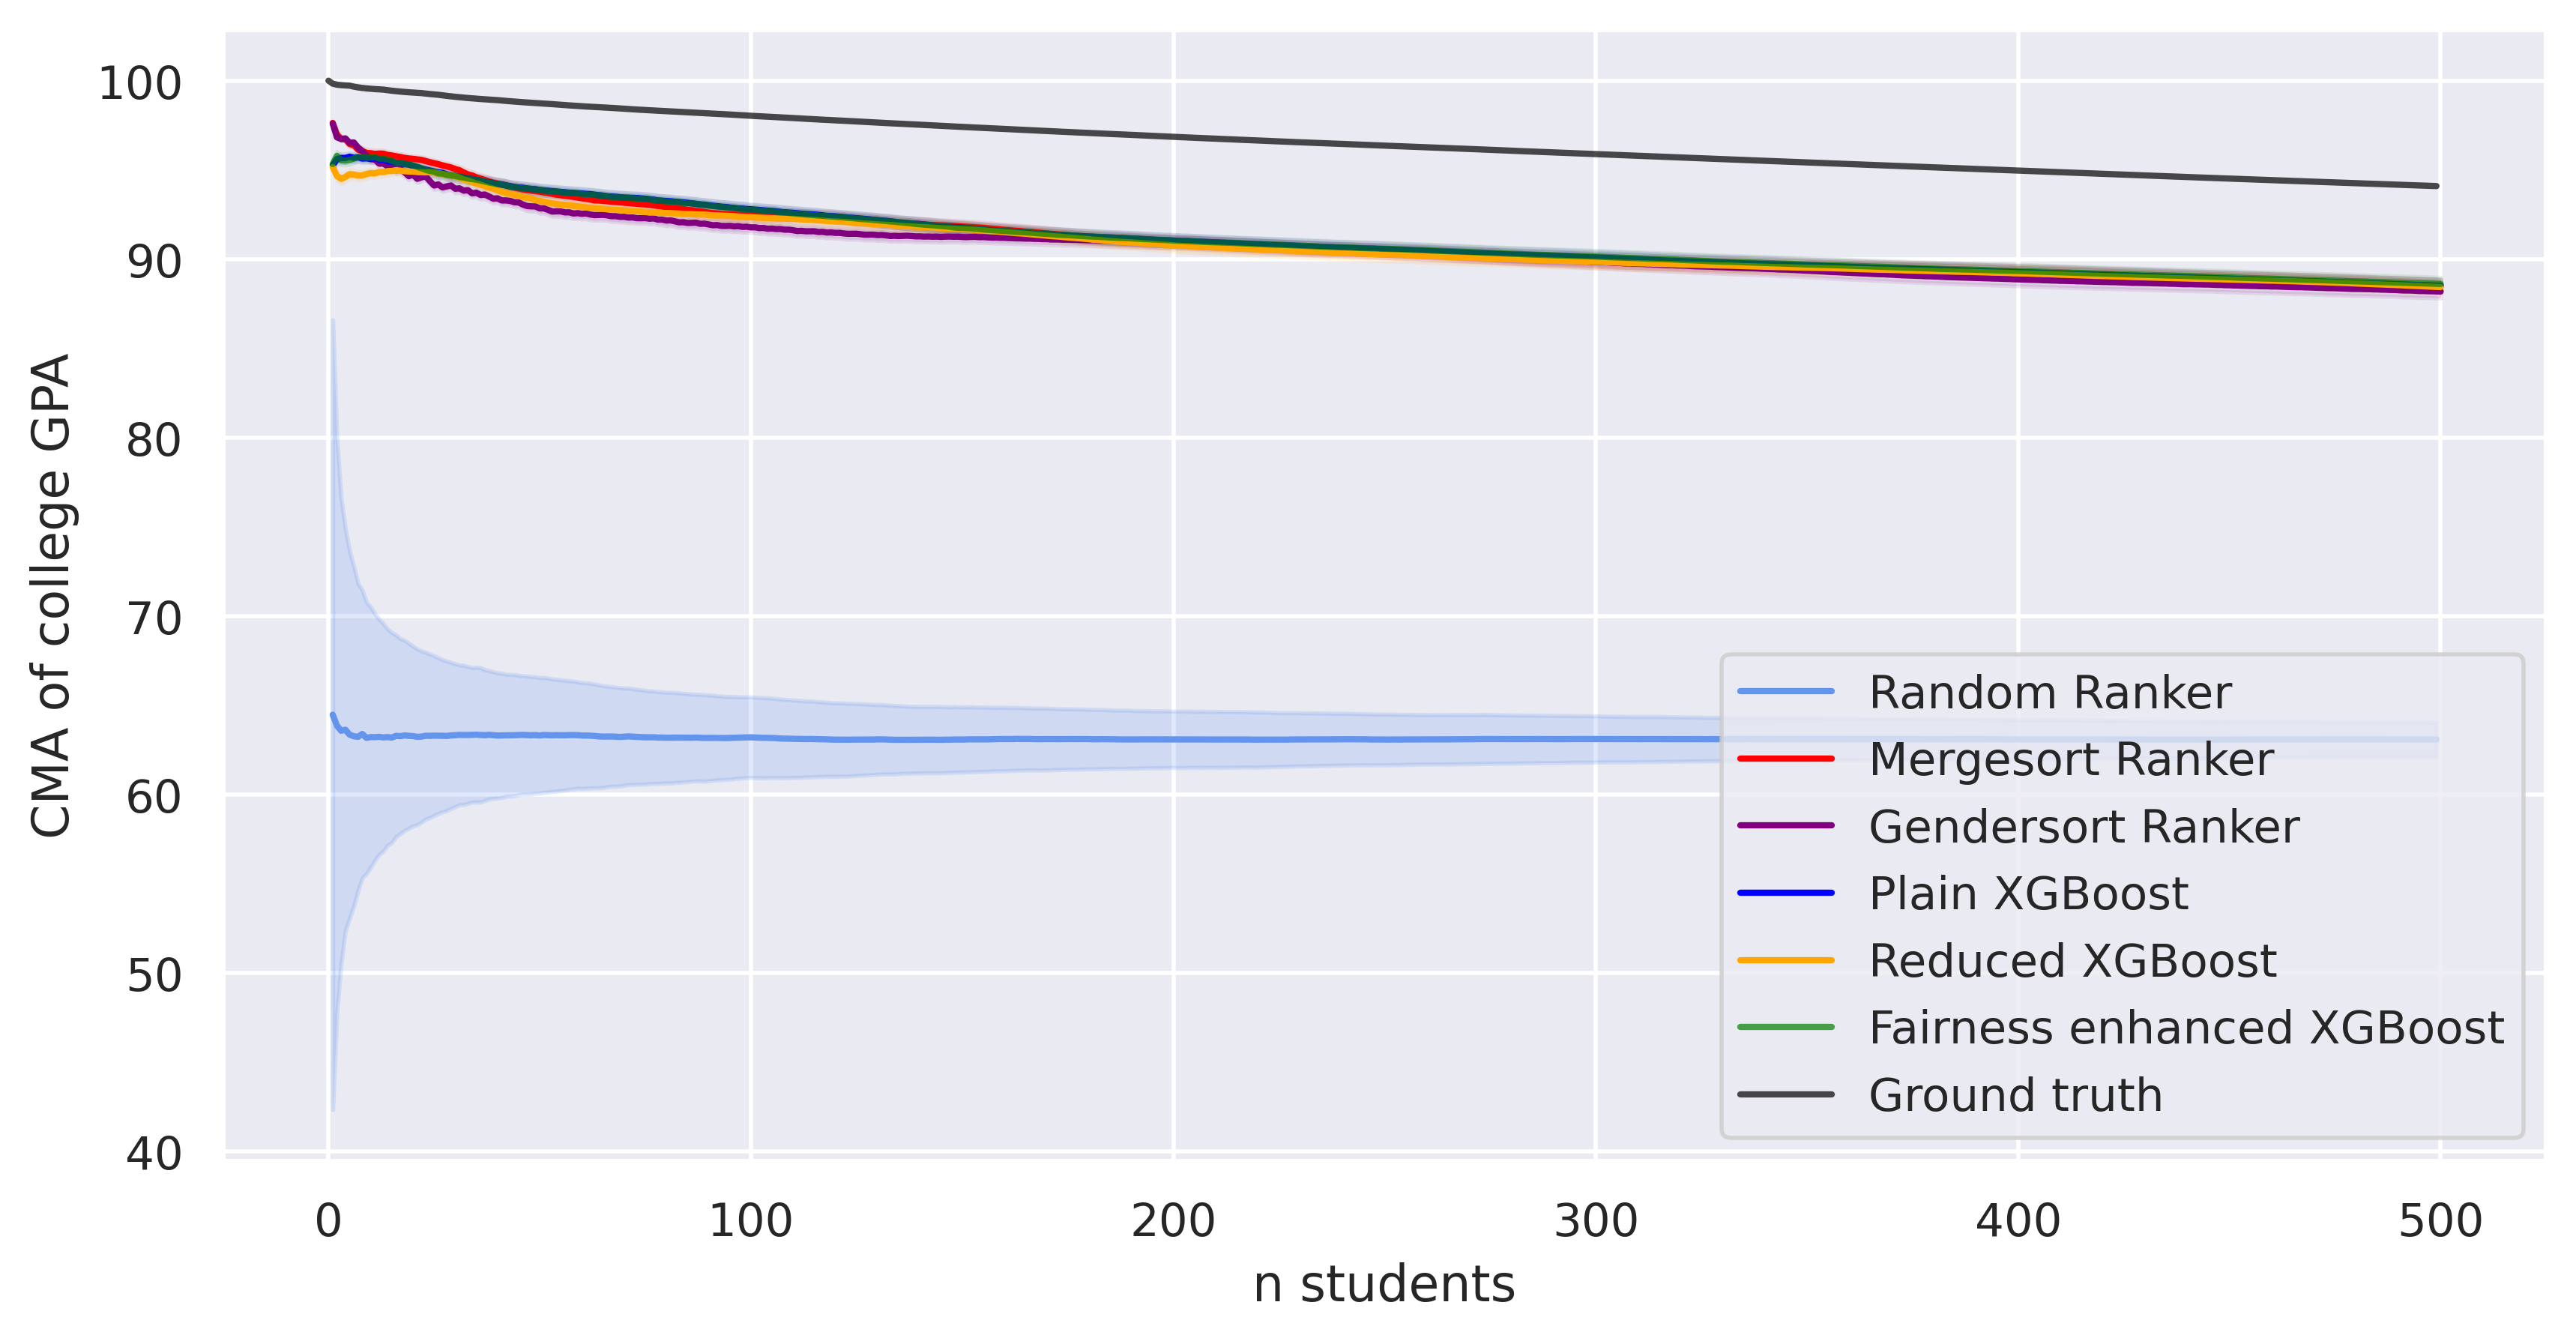

In [60]:
# xgboost 200
k=0
l=500


# random
sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd", color="cornflowerblue")


# Mergesort and gendersort rankers
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[k:l], color="red")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG[k:l], alpha=0.1, color="red")

sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df_BIG[k:l], color="purple")
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG[k:l], alpha=0.1, color="purple")


# XGBoosts
sns.lineplot(data=Merged_PLAIN[k:l], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_PLAIN[k:l], alpha=0.1, color="blue")

sns.lineplot(data=Merged_WO[k:l], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_WO[k:l], alpha=0.1, color="orange")

sns.lineplot(data=Merged_FAIR[k:l], x="n_students", y="incr_col_mean",  color="green" , ci="sd", alpha=0.7)
plt.fill_between("n_students", "lower_std", "upper_std",data=Merged_FAIR[k:l], alpha=0.1, color="green")

GT["incr_col_mean"] = GT['y_test'].expanding().mean()
sns.lineplot(data=GT[k:l], x="rank_y_test", y="incr_col_mean",  color="black" , ci="sd", alpha=0.7)



#plot
plt.xlabel('n students')
plt.ylabel('CMA of college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
#plt.title('Utility of models - College GPA, all rankers')
plt.legend([ 'Random Ranker',"Mergesort Ranker",'Gendersort Ranker',"Plain XGBoost", "Reduced XGBoost", "Fairness enhanced XGBoost", 'Ground truth'], loc ="lower right")
#plt.legend(["Mergesort Ranker", "Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")

plt.show()
# plt.savefig('ALL_utility.png')

## Kruskal Wallis test


In [41]:
GT = pd.read_csv('GT.csv')

In [42]:
from scipy import stats
k=0
l=500

gt = GT["y_test"][k:l]
plainxgb = Merged_PLAIN["COL_GRADE_AVG"][k:l]
woxgb = Merged_WO["COL_GRADE_AVG"][k:l]
fairxgb =  Merged_FAIR["COL_GRADE_AVG"][k:l]
mergesort = df_sort_BIG["18"][k:l]
gendersort = gender_df_BIG['18_x'][k:l]


The null hypothesis states that the population medians for these groups are all equal.
The p-value is larger than alpha = 0.05, and therefore we can not reject the hypotesis, that the medians are equal. 


P-value ≤ α: The differences between some of the medians are statistically significant:
significant difference between 

In [43]:

pvalues1=pd.read_csv('pvalues1.csv')
pvalues2=pd.read_csv('pvalues2.csv') 
pvalues3=pd.read_csv('pvalues3.csv')
pvalues4=pd.read_csv('pvalues4.csv') 
pvalues5=pd.read_csv('pvalues5.csv') 

MER_pvalues = pd.DataFrame(columns=['100','200','300','400','500'])
MER_pvalues['100']=pvalues1['Mer']
MER_pvalues['200']=pvalues2['Mer']
MER_pvalues['300']=pvalues3['Mer']
MER_pvalues['400']=pvalues4['Mer']
MER_pvalues['500']=pvalues5['Mer']

GEN_pvalues = pd.DataFrame(columns=['100','200','300','400','500'])
GEN_pvalues['100']=pvalues1['Gen']
GEN_pvalues['200']=pvalues2['Gen']
GEN_pvalues['300']=pvalues3['Gen']
GEN_pvalues['400']=pvalues4['Gen']
GEN_pvalues['500']=pvalues5['Gen']

PLA_pvalues = pd.DataFrame(columns=['100','200','300','400','500'])
PLA_pvalues['100']=pvalues1['Pla']
PLA_pvalues['200']=pvalues2['Pla']
PLA_pvalues['300']=pvalues3['Pla']
PLA_pvalues['400']=pvalues4['Pla']
PLA_pvalues['500']=pvalues5['Pla']

WO_pvalues = pd.DataFrame(columns=['100','200','300','400','500'])
WO_pvalues['100']=pvalues1['Wo']
WO_pvalues['200']=pvalues2['Wo']
WO_pvalues['300']=pvalues3['Wo']
WO_pvalues['400']=pvalues4['Wo']
WO_pvalues['500']=pvalues5['Wo']
FAI_pvalues = pd.DataFrame(columns=['100','200','300','400','500'])
FAI_pvalues['100']=pvalues1['Fai']
FAI_pvalues['200']=pvalues2['Fai']
FAI_pvalues['300']=pvalues3['Fai']
FAI_pvalues['400']=pvalues4['Fai']
FAI_pvalues['500']=pvalues5['Fai']

MER_pvalues=MER_pvalues.rename(index={1:'Gendersort', 2:'Plain xgb',3:'W/o sens. xgb',4:'Fairness xgb'}).drop([0], axis=0)
GEN_pvalues=GEN_pvalues.rename(index={0:'Mergesort',1:'Gendersort', 2:'Plain xgb',3:'W/o sens. xgb',4:'Fairness xgb'}).drop(['Gendersort'], axis=0)
PLA_pvalues=PLA_pvalues.rename(index={0:'Mergesort',1:'Gendersort', 2:'Plain xgb',3:'W/o sens. xgb',4:'Fairness xgb'}).drop(['Plain xgb'], axis=0)
WO_pvalues=WO_pvalues.rename(index={0:'Mergesort',1:'Gendersort', 2:'Plain xgb',3:'W/o sens. xgb',4:'Fairness xgb'}).drop(['W/o sens. xgb'], axis=0)
FAI_pvalues=FAI_pvalues.rename(index={0:'Mergesort',1:'Gendersort', 2:'Plain xgb',3:'W/o sens. xgb',4:'Fairness xgb'}).drop(['Fairness xgb'], axis=0)


MER_pvalues = MER_pvalues.T
GEN_pvalues = GEN_pvalues.T
PLA_pvalues = PLA_pvalues.T
WO_pvalues = WO_pvalues.T
FAI_pvalues = FAI_pvalues.T


In [44]:
liste = []
for l in range(0,4000,100):
    plainxgb=Merged_PLAIN["COL_GRADE_AVG"][k:l]
    fairxgb =  Merged_FAIR["COL_GRADE_AVG"][k:l]
    liste.append(stats.kruskal(plainxgb, fairxgb)[1])
len(liste)
indexxx = np.arange(0,4000,100)

fair_plain = pd.DataFrame(columns=['n_students','p_vals'])
fair_plain['n_students']=indexxx
fair_plain['p_vals'] = liste


## P-values comparison - Plain XGBoost

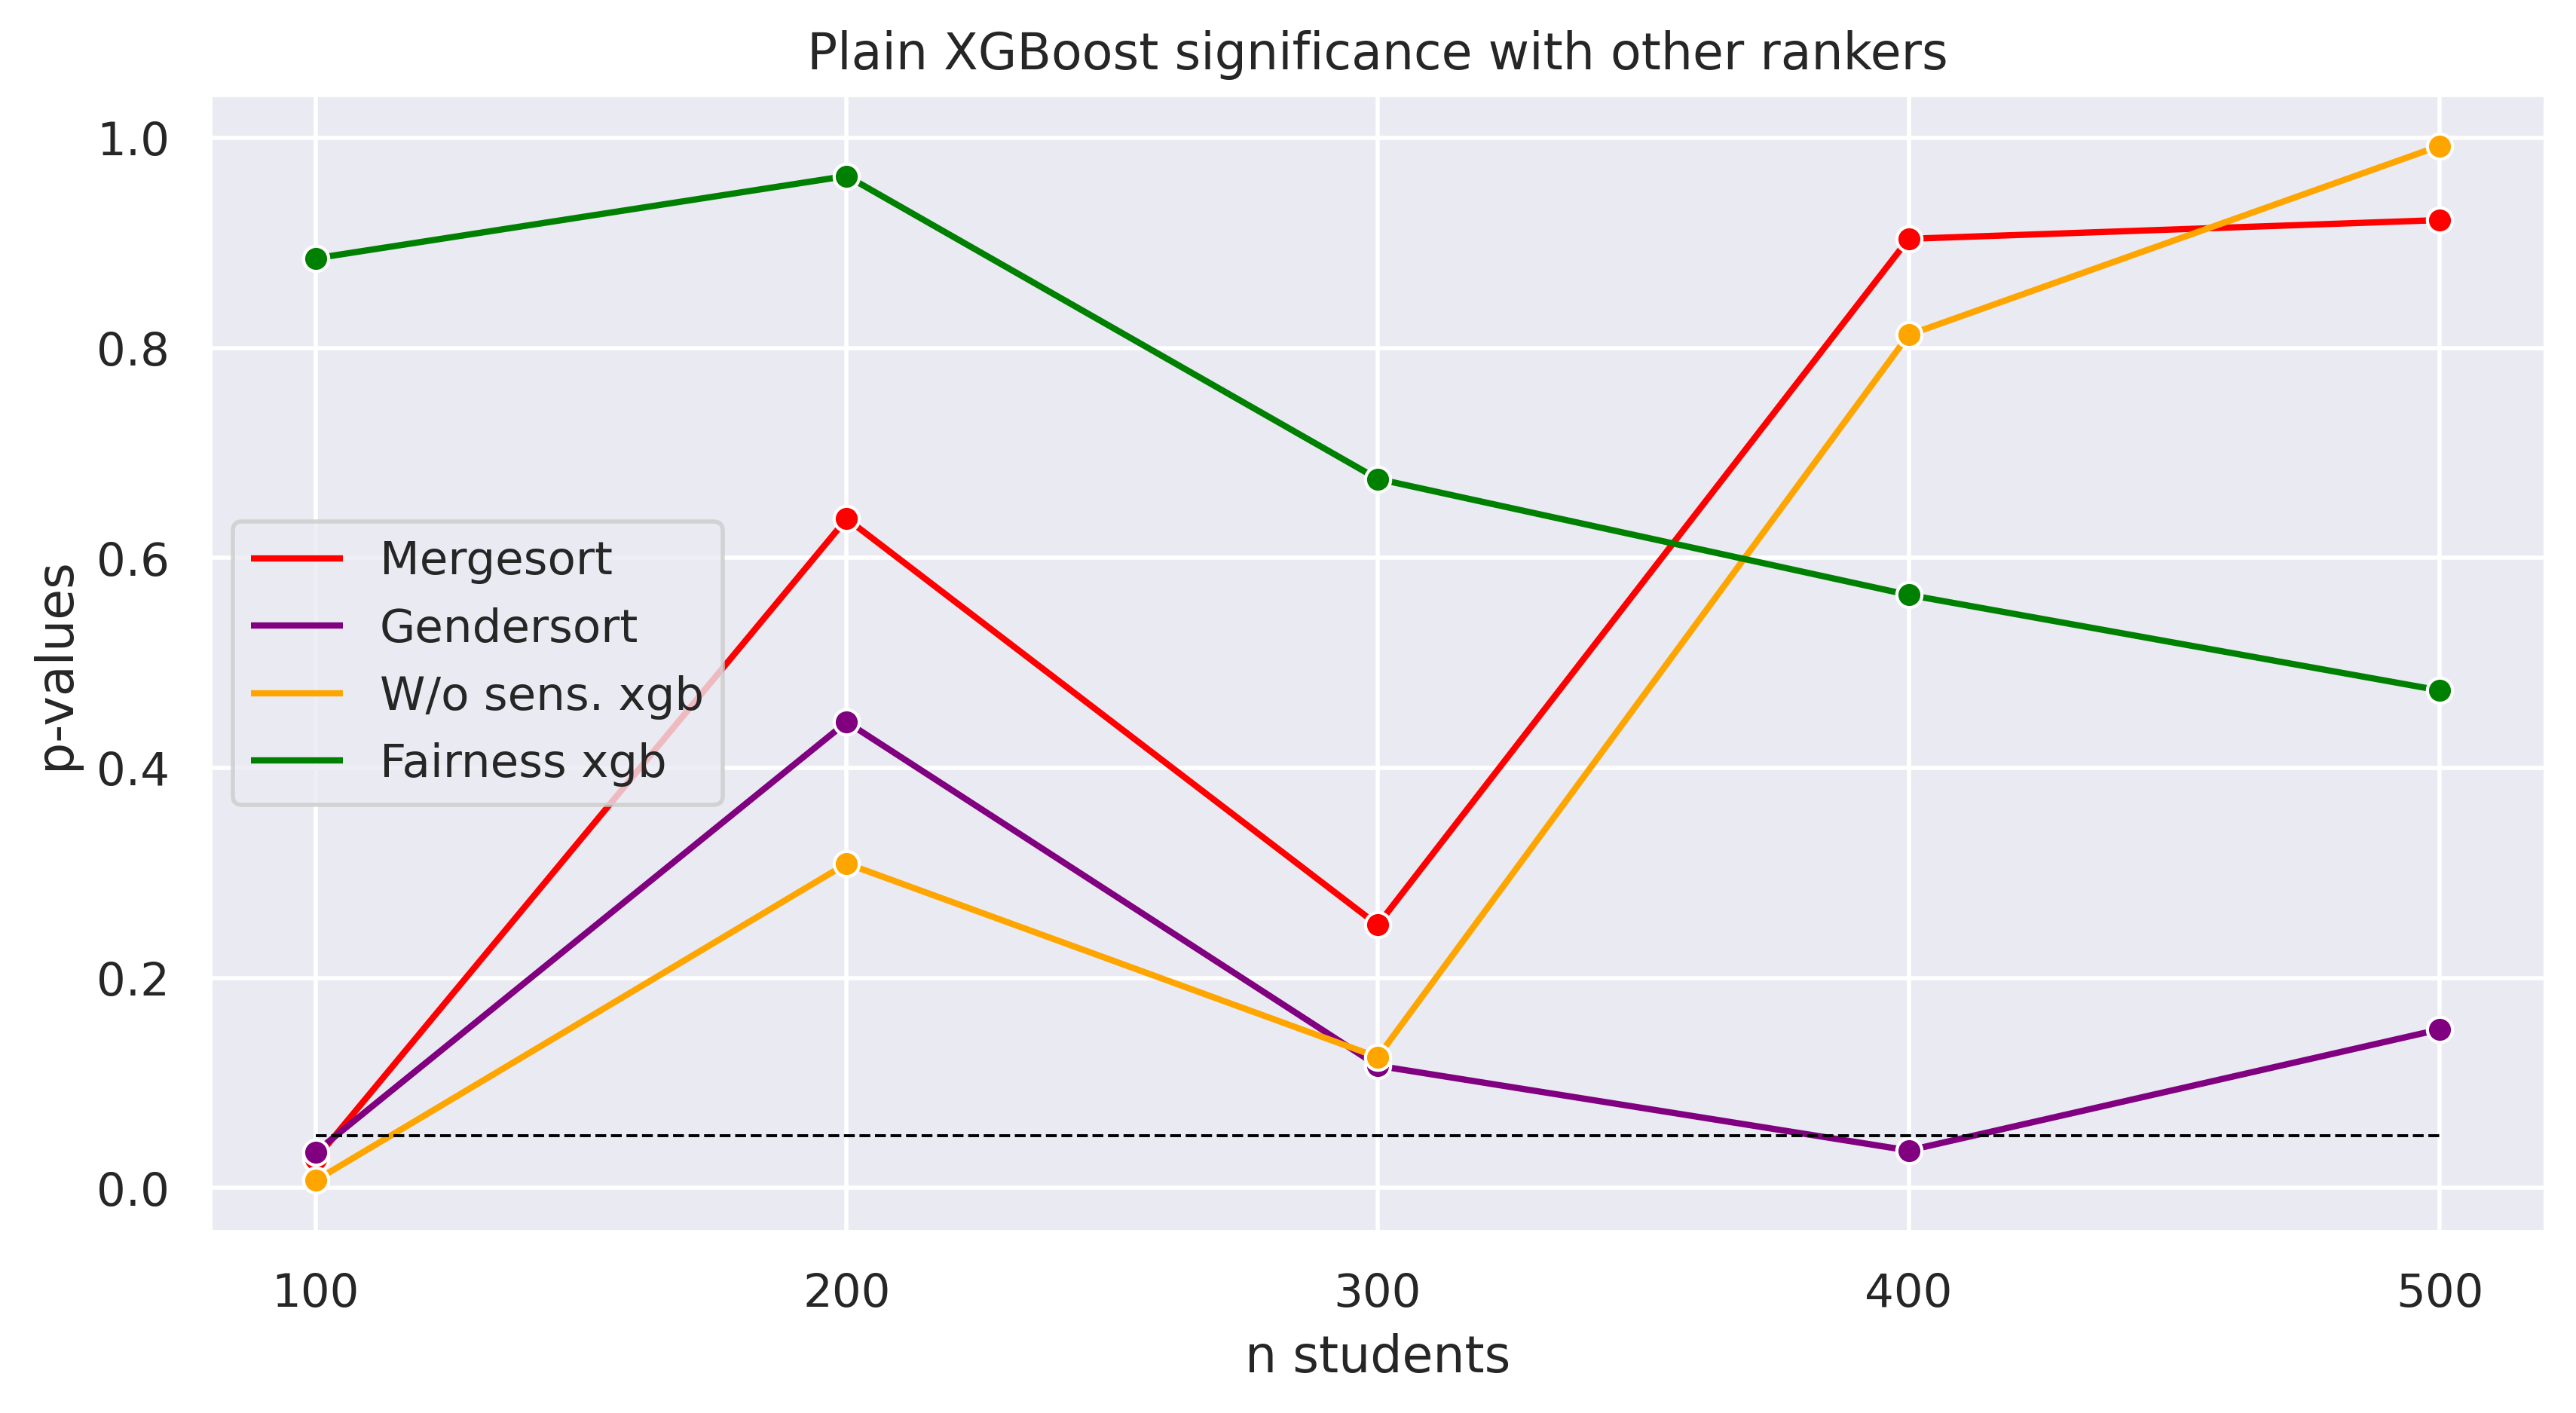

In [45]:
colors = ['red', "purple",'orange','green']
customPalette = sns.set_palette(sns.color_palette(colors))
sns.lineplot(data=PLA_pvalues,linestyle='-', marker='o', palette = customPalette, dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0, 5, 1)
Y_plot = 0.05+X_plot*0
plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')
plt.xlabel('n students')
plt.ylabel('p-values')

plt.title('Plain XGBoost significance with other rankers')
plt.show()

## P-values comparison - Mergesort

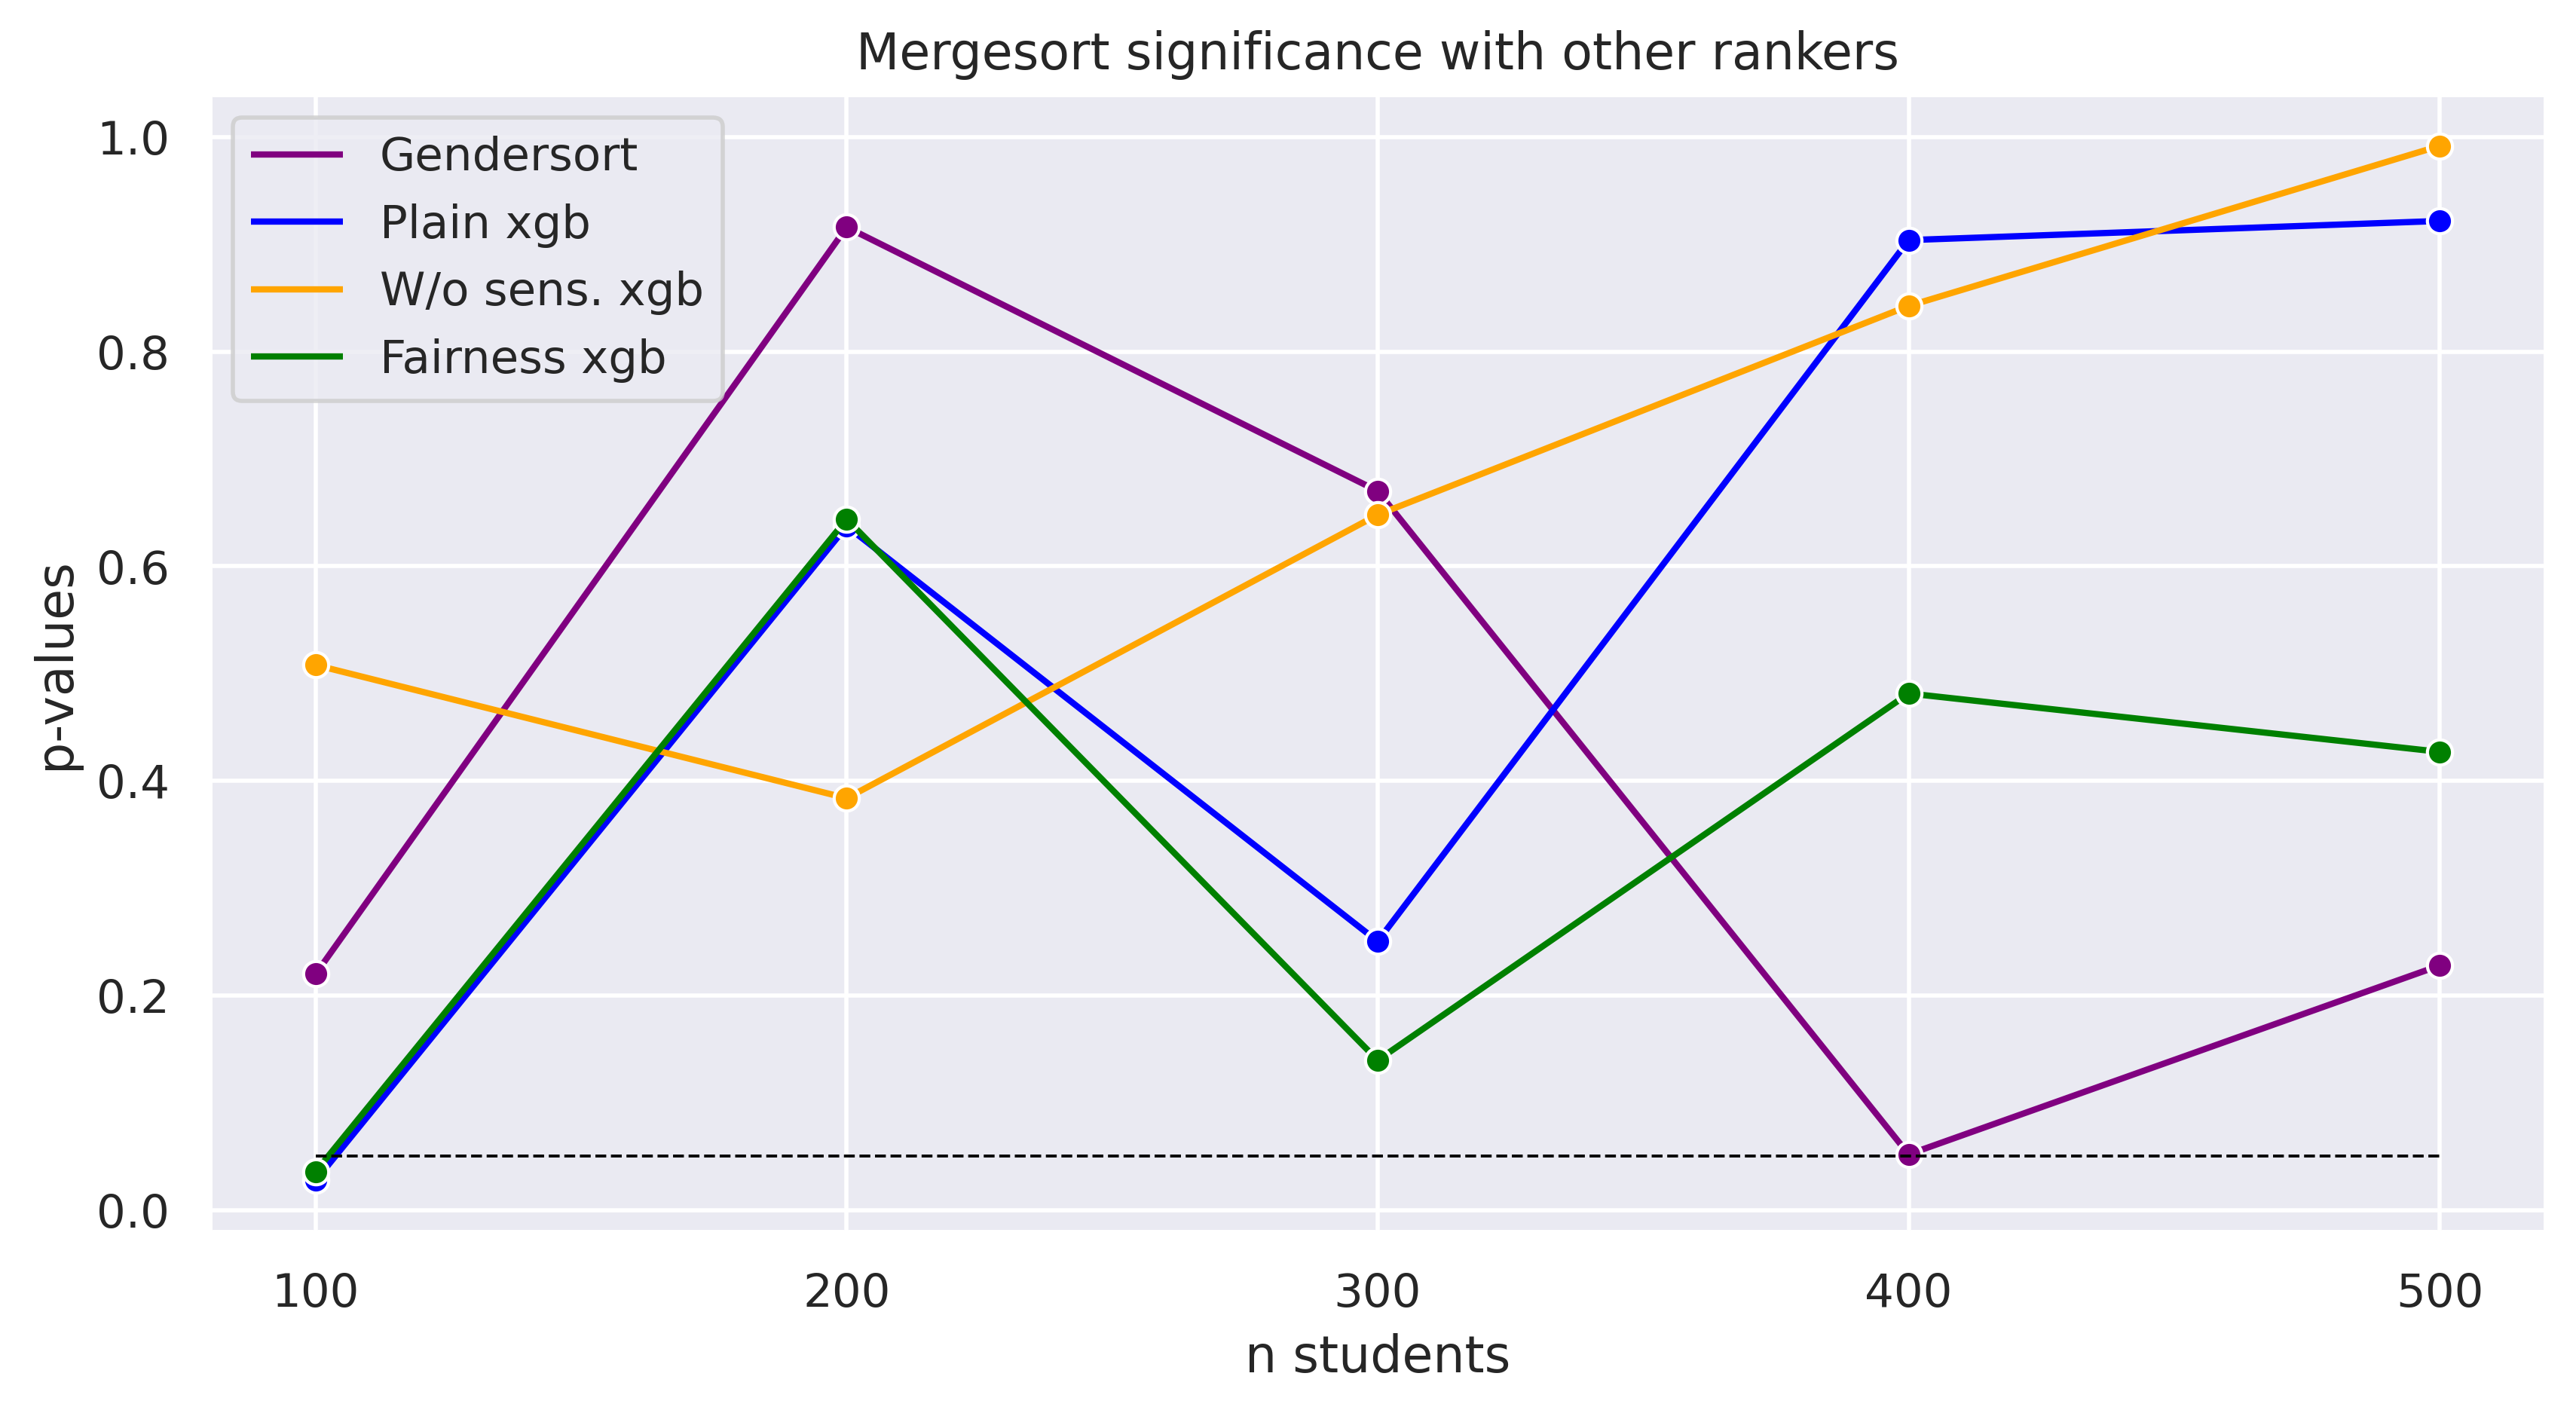

In [46]:
colors = ['purple','blue','orange','green']
customPalette = sns.set_palette(sns.color_palette(colors))

sns.lineplot(data=MER_pvalues,linestyle='-', marker='o', palette = customPalette, dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0, 5, 1)
Y_plot = 0.05+X_plot*0

plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')
plt.xlabel('n students')
plt.ylabel('p-values')

plt.title('Mergesort significance with other rankers')
plt.show()

## P-values comparison - Gendersort

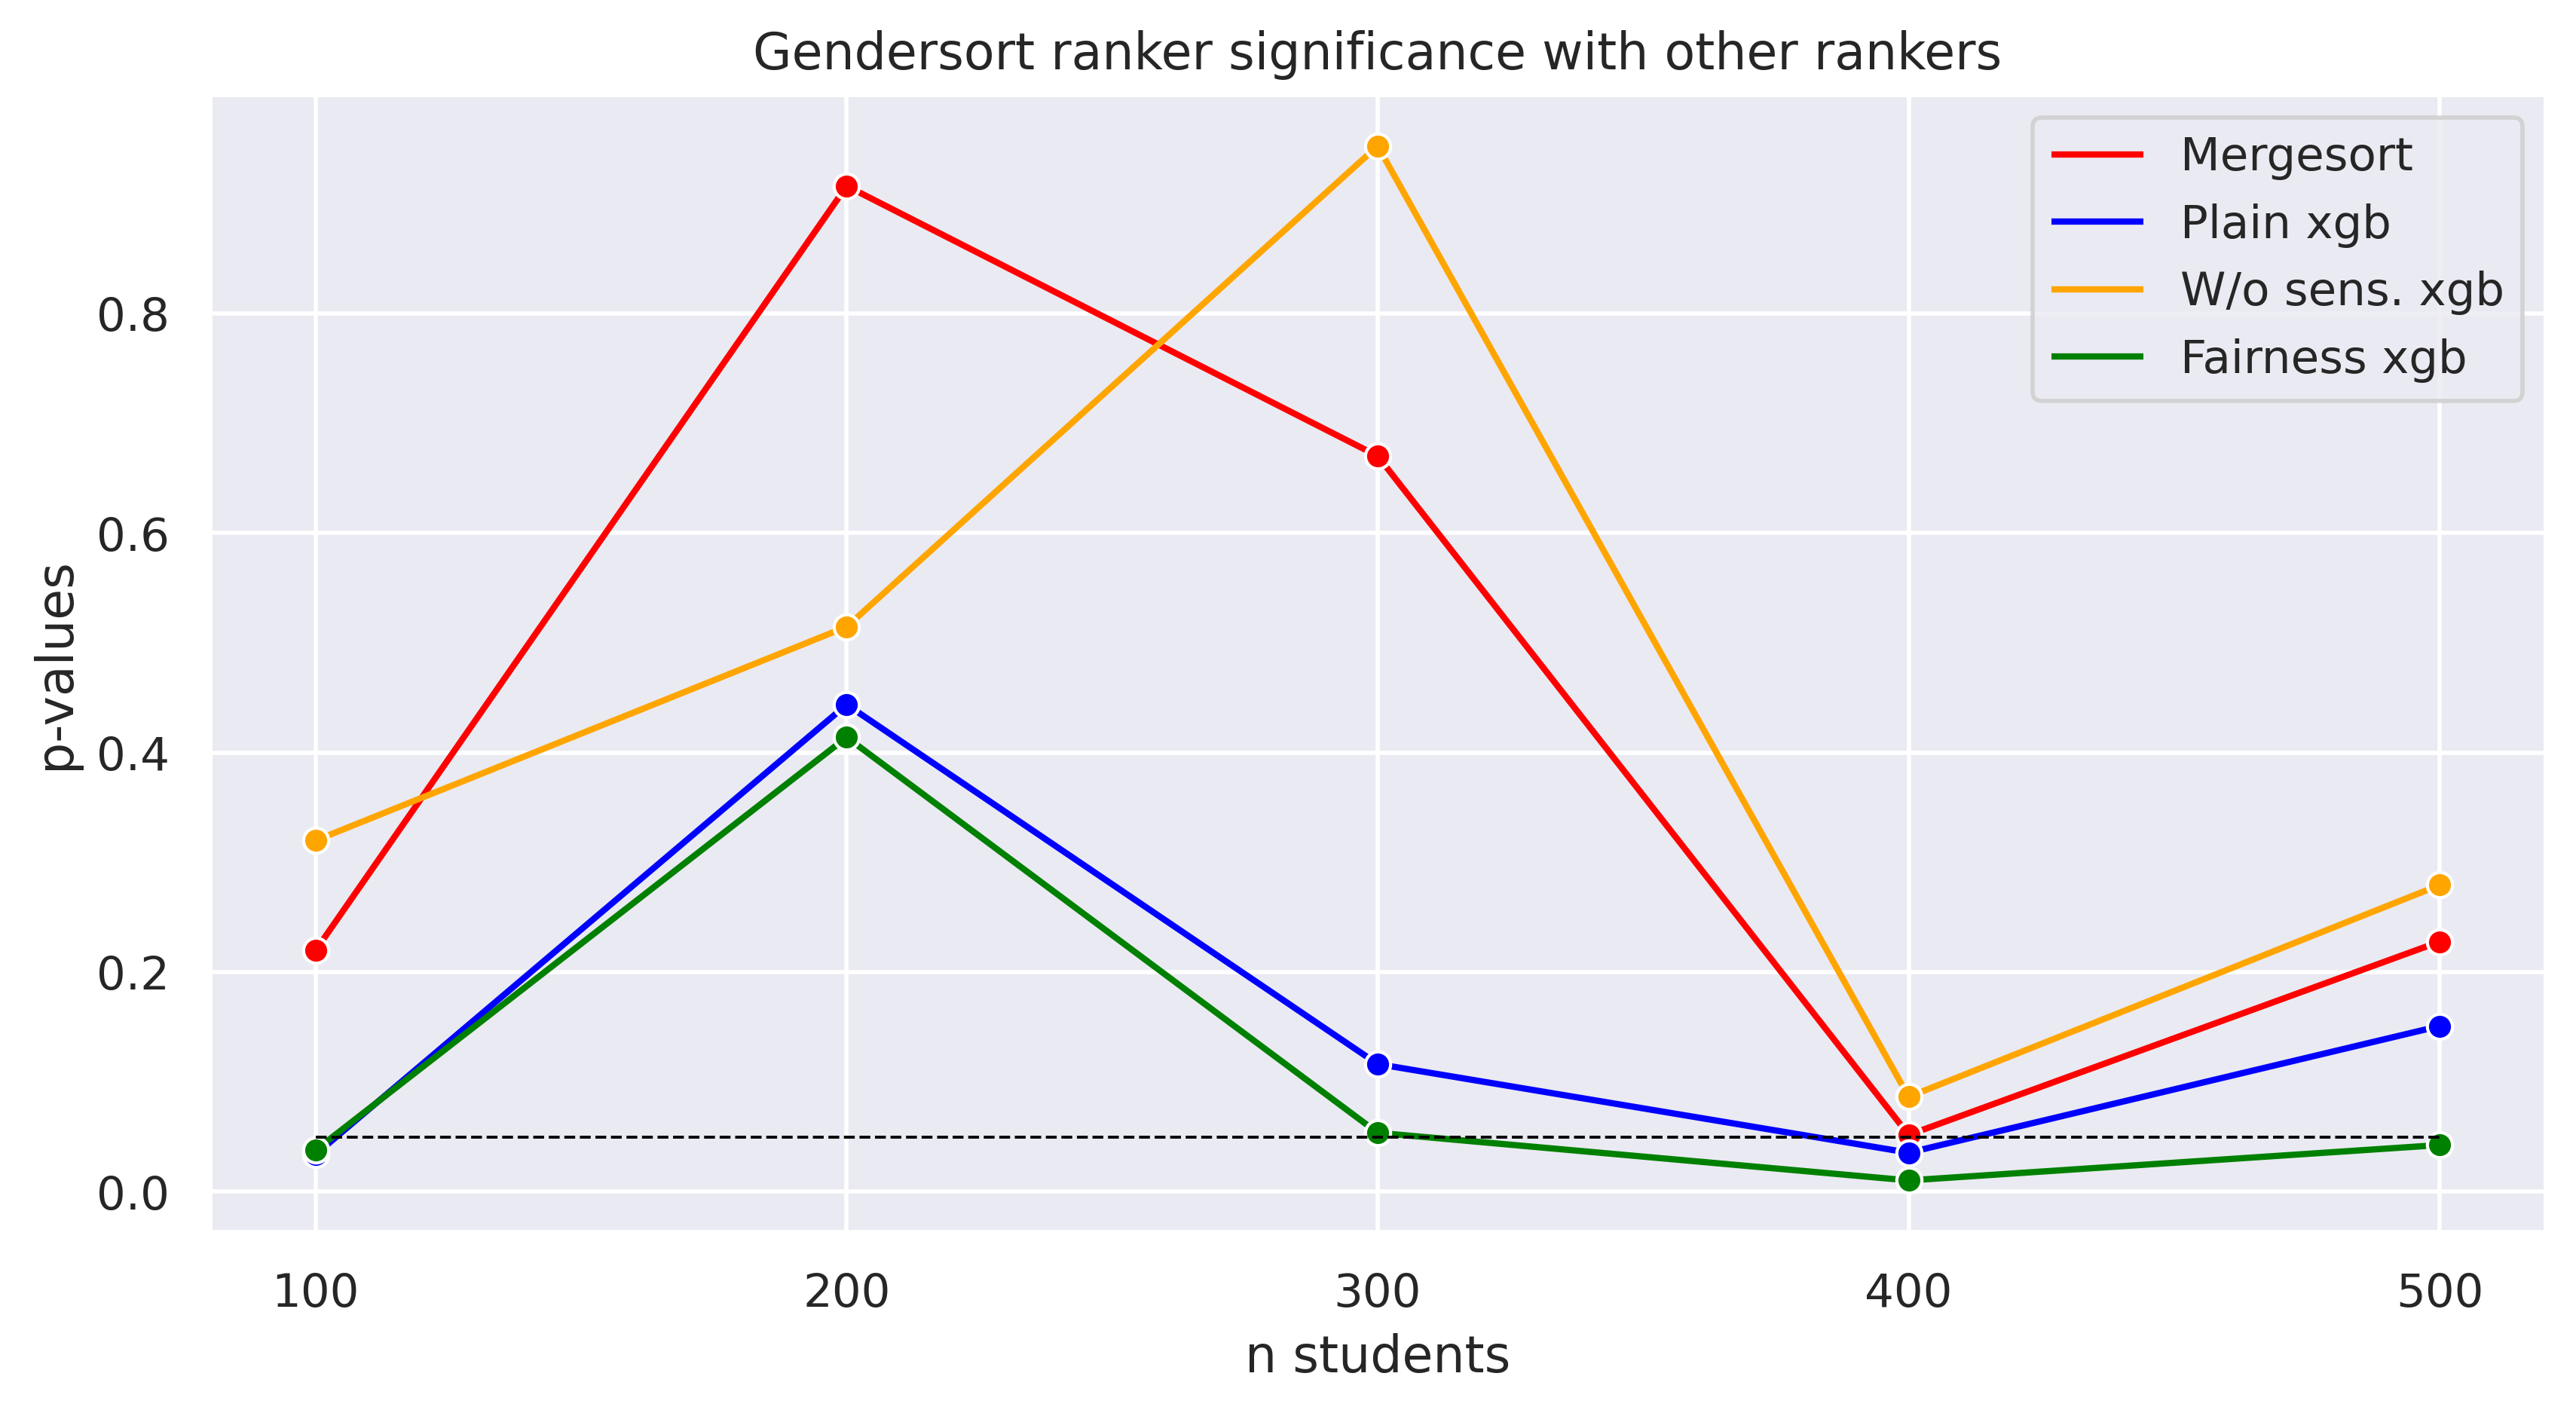

In [47]:
colors = ['red','blue','orange','green']
customPalette = sns.set_palette(sns.color_palette(colors))

sns.lineplot(data=GEN_pvalues,linestyle='-', marker='o', palette = customPalette, dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0, 5, 1)
Y_plot = 0.05+X_plot*0

plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')
plt.xlabel('n students')
plt.ylabel('p-values')

plt.title('Gendersort ranker significance with other rankers')
plt.show()

## P-values comparison - Reduced XGBoost

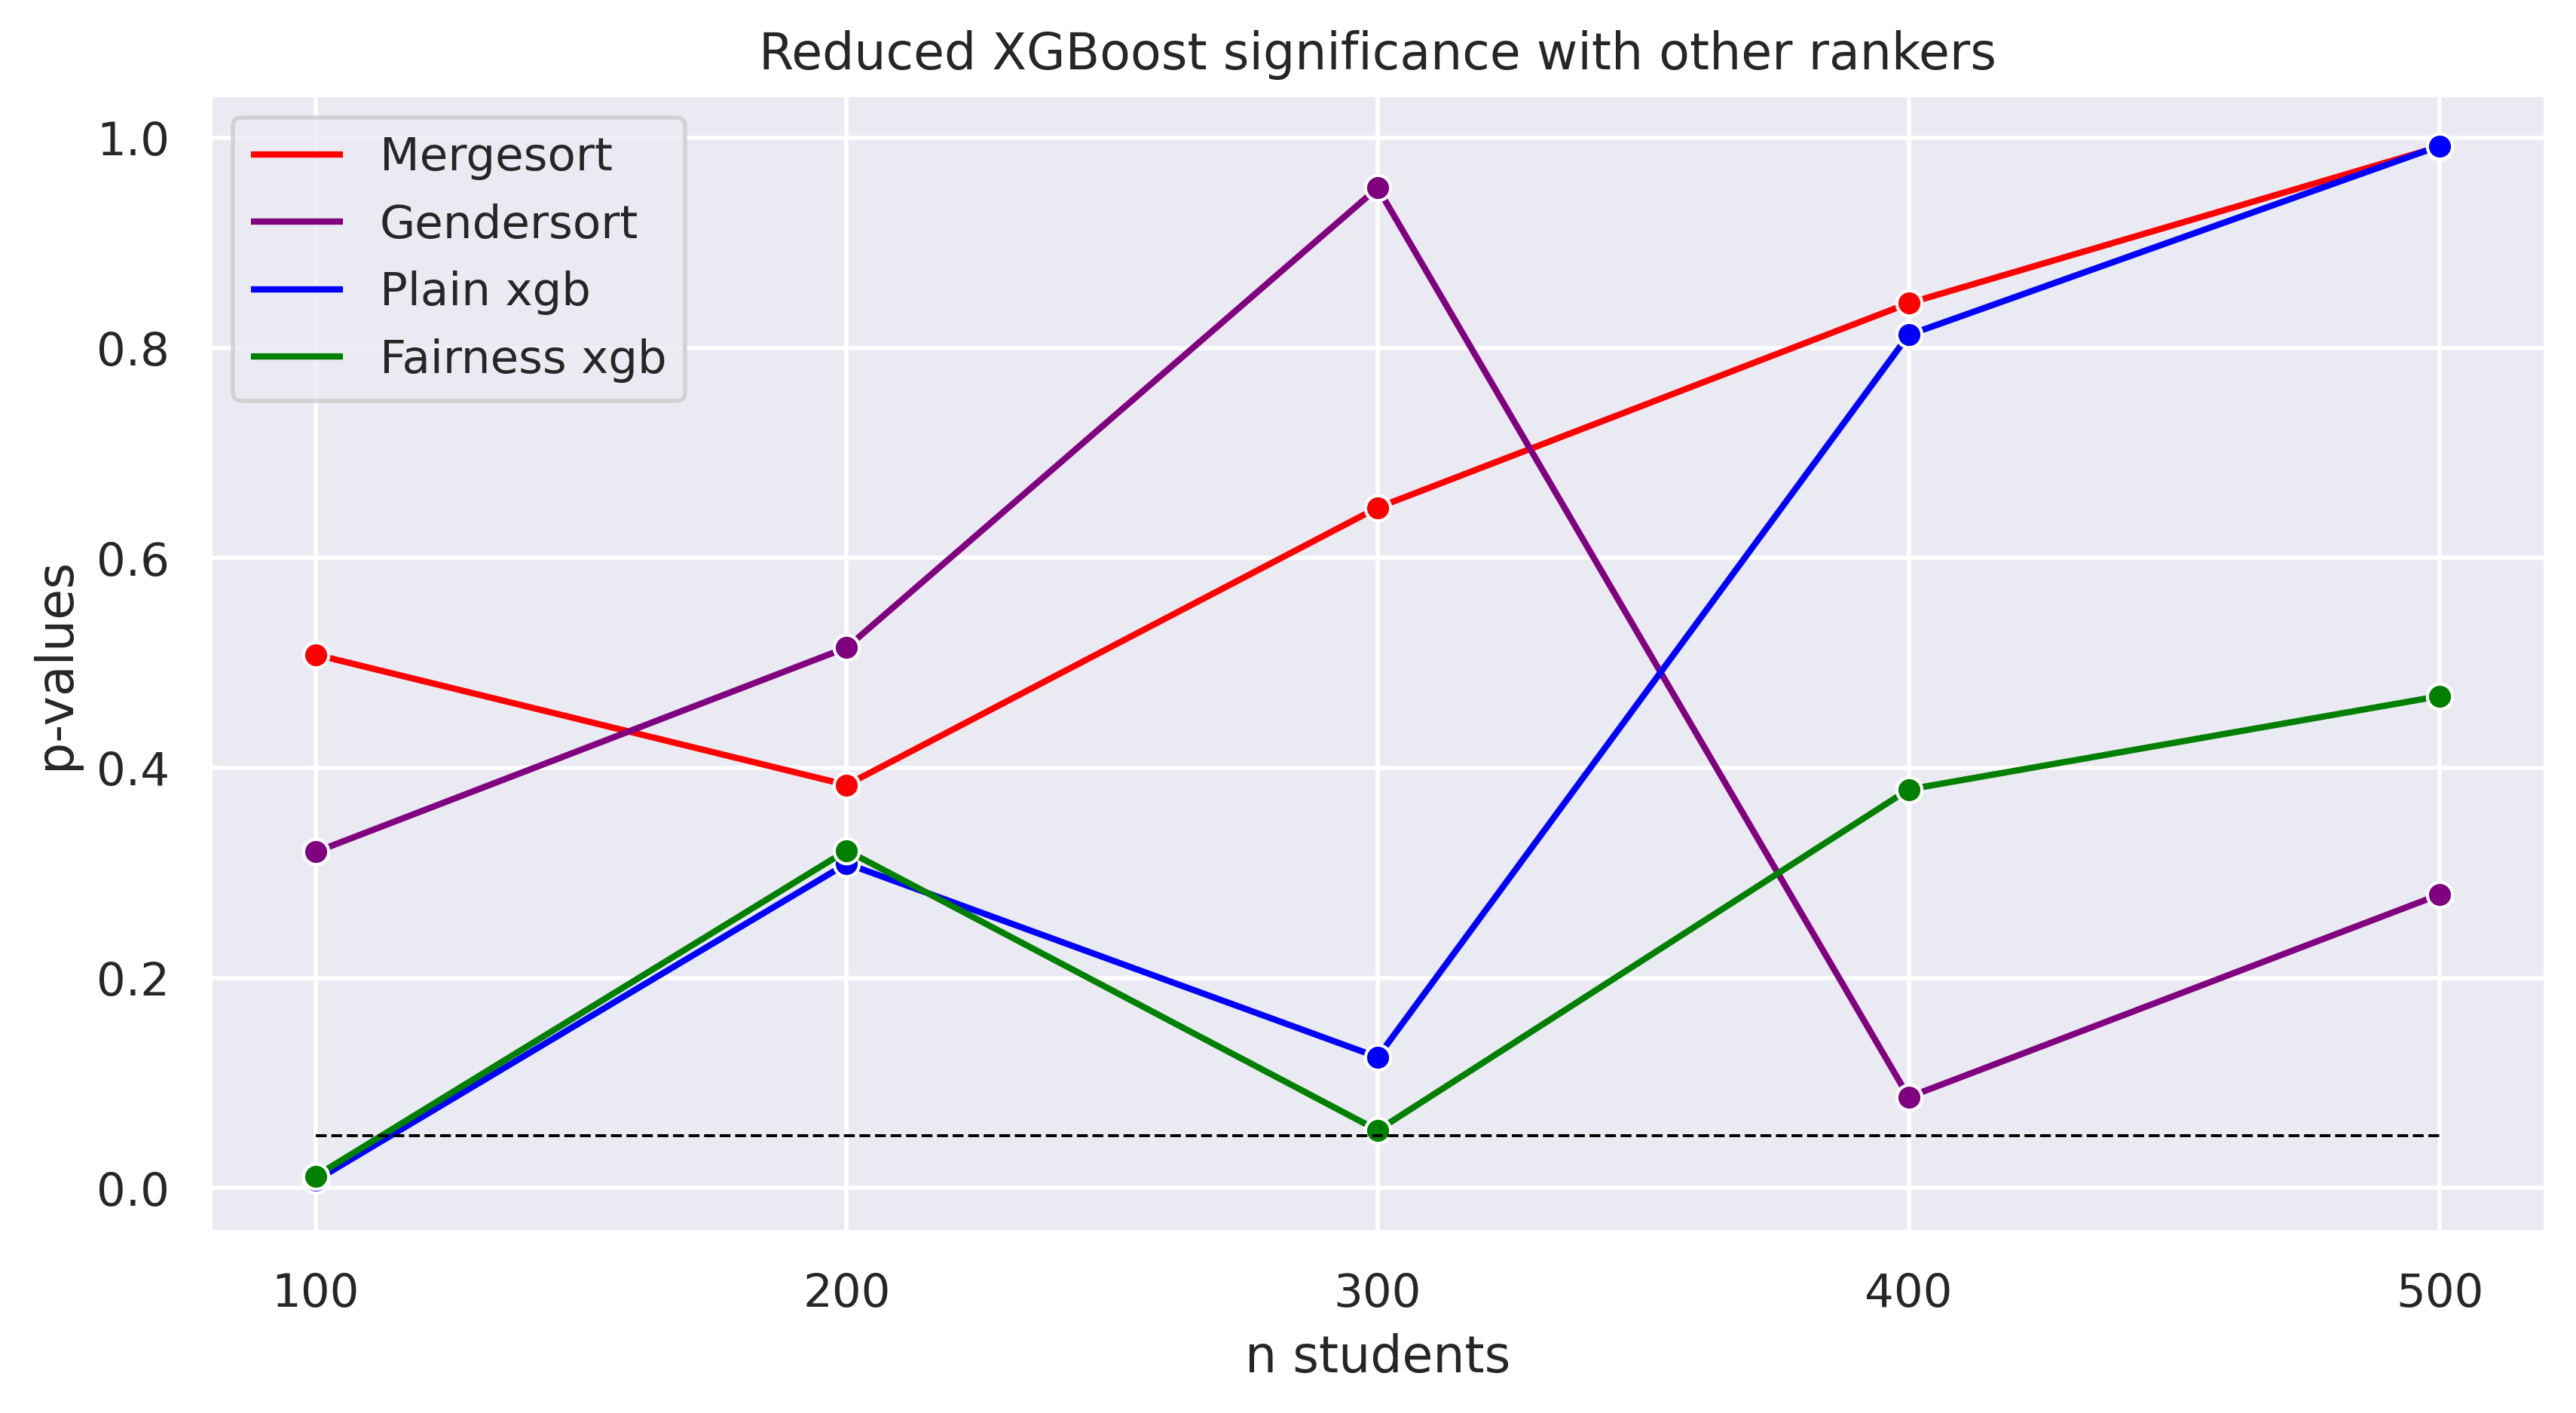

In [48]:
colors = ['red','purple','blue','green']
customPalette = sns.set_palette(sns.color_palette(colors))

sns.lineplot(data=WO_pvalues,linestyle='-', marker='o', palette = customPalette, dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0, 5, 1)
Y_plot = 0.05+X_plot*0

plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')
plt.xlabel('n students')
plt.ylabel('p-values')

plt.title('Reduced XGBoost significance with other rankers')
plt.show()

## P-values comparison - Fairness enhanced XGBoost

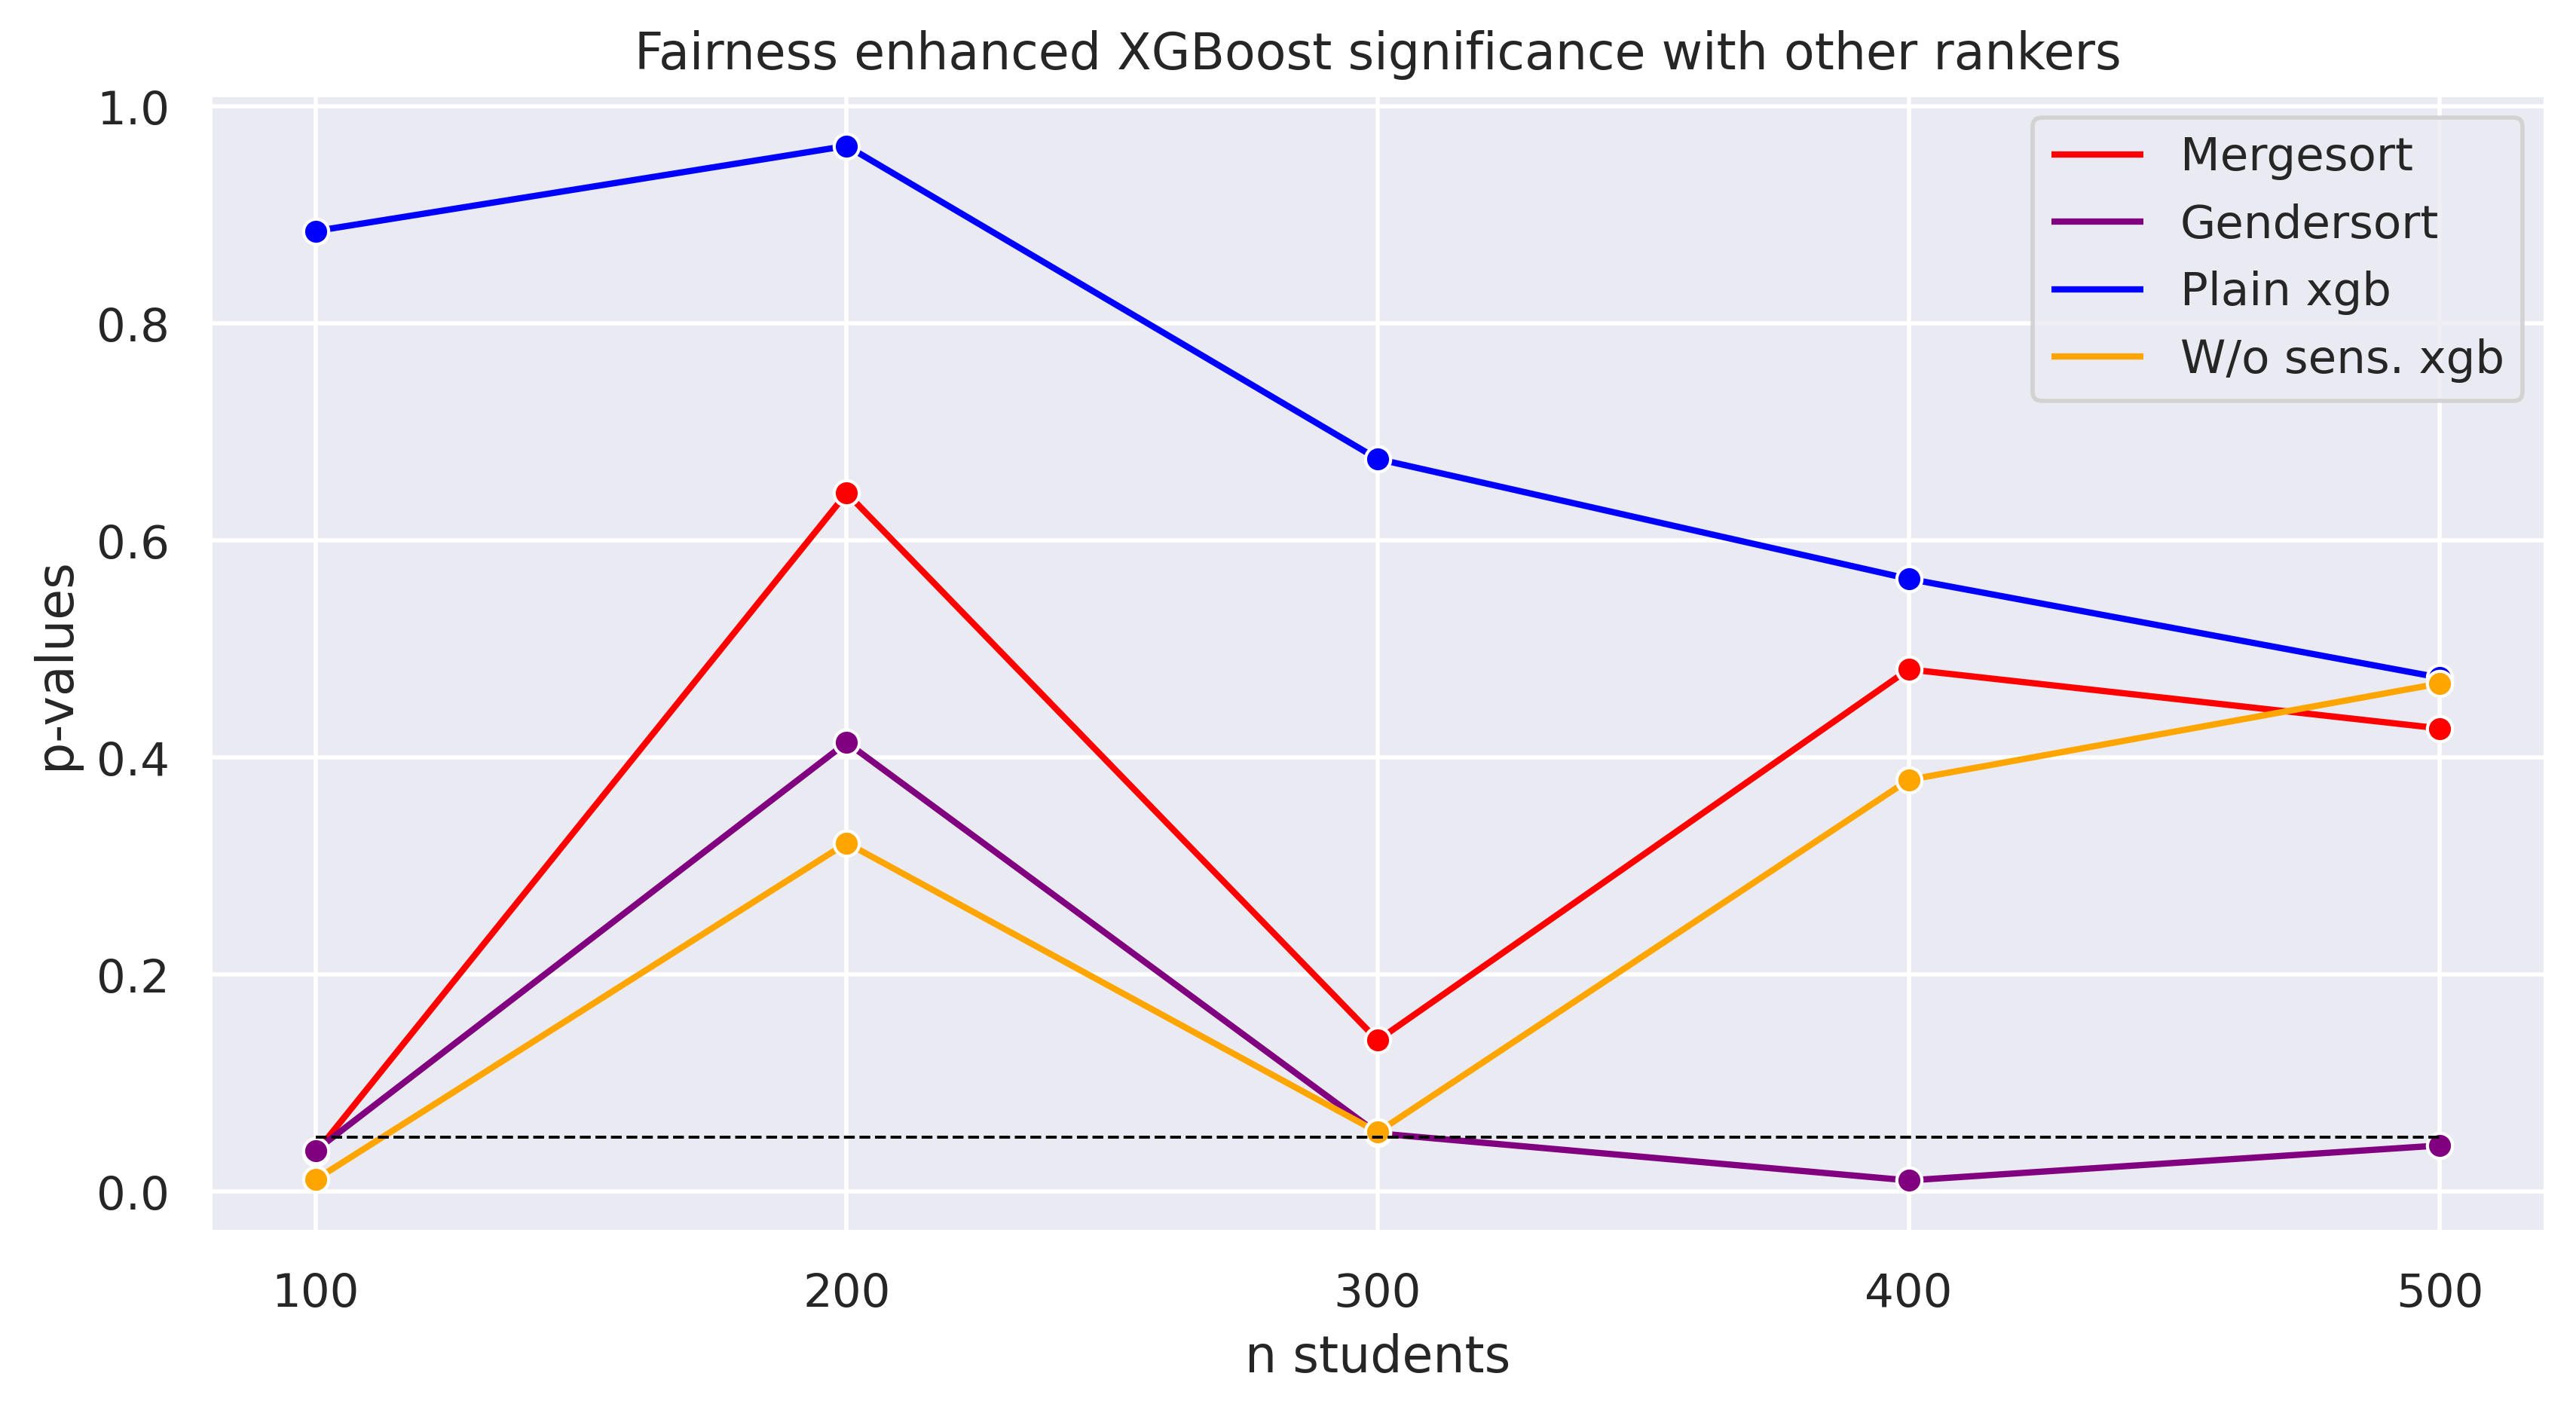

In [49]:
colors = ['red','purple','blue','orange']
customPalette = sns.set_palette(sns.color_palette(colors))

sns.lineplot(data=FAI_pvalues,linestyle='-', marker='o', palette = customPalette, dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0, 5, 1)
Y_plot = 0.05+X_plot*0

plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')
plt.xlabel('n students')
plt.ylabel('p-values')

plt.title('Fairness enhanced XGBoost significance with other rankers')
plt.show()

## The Plain and Fairness enhances XGBoost significance for top-4000 

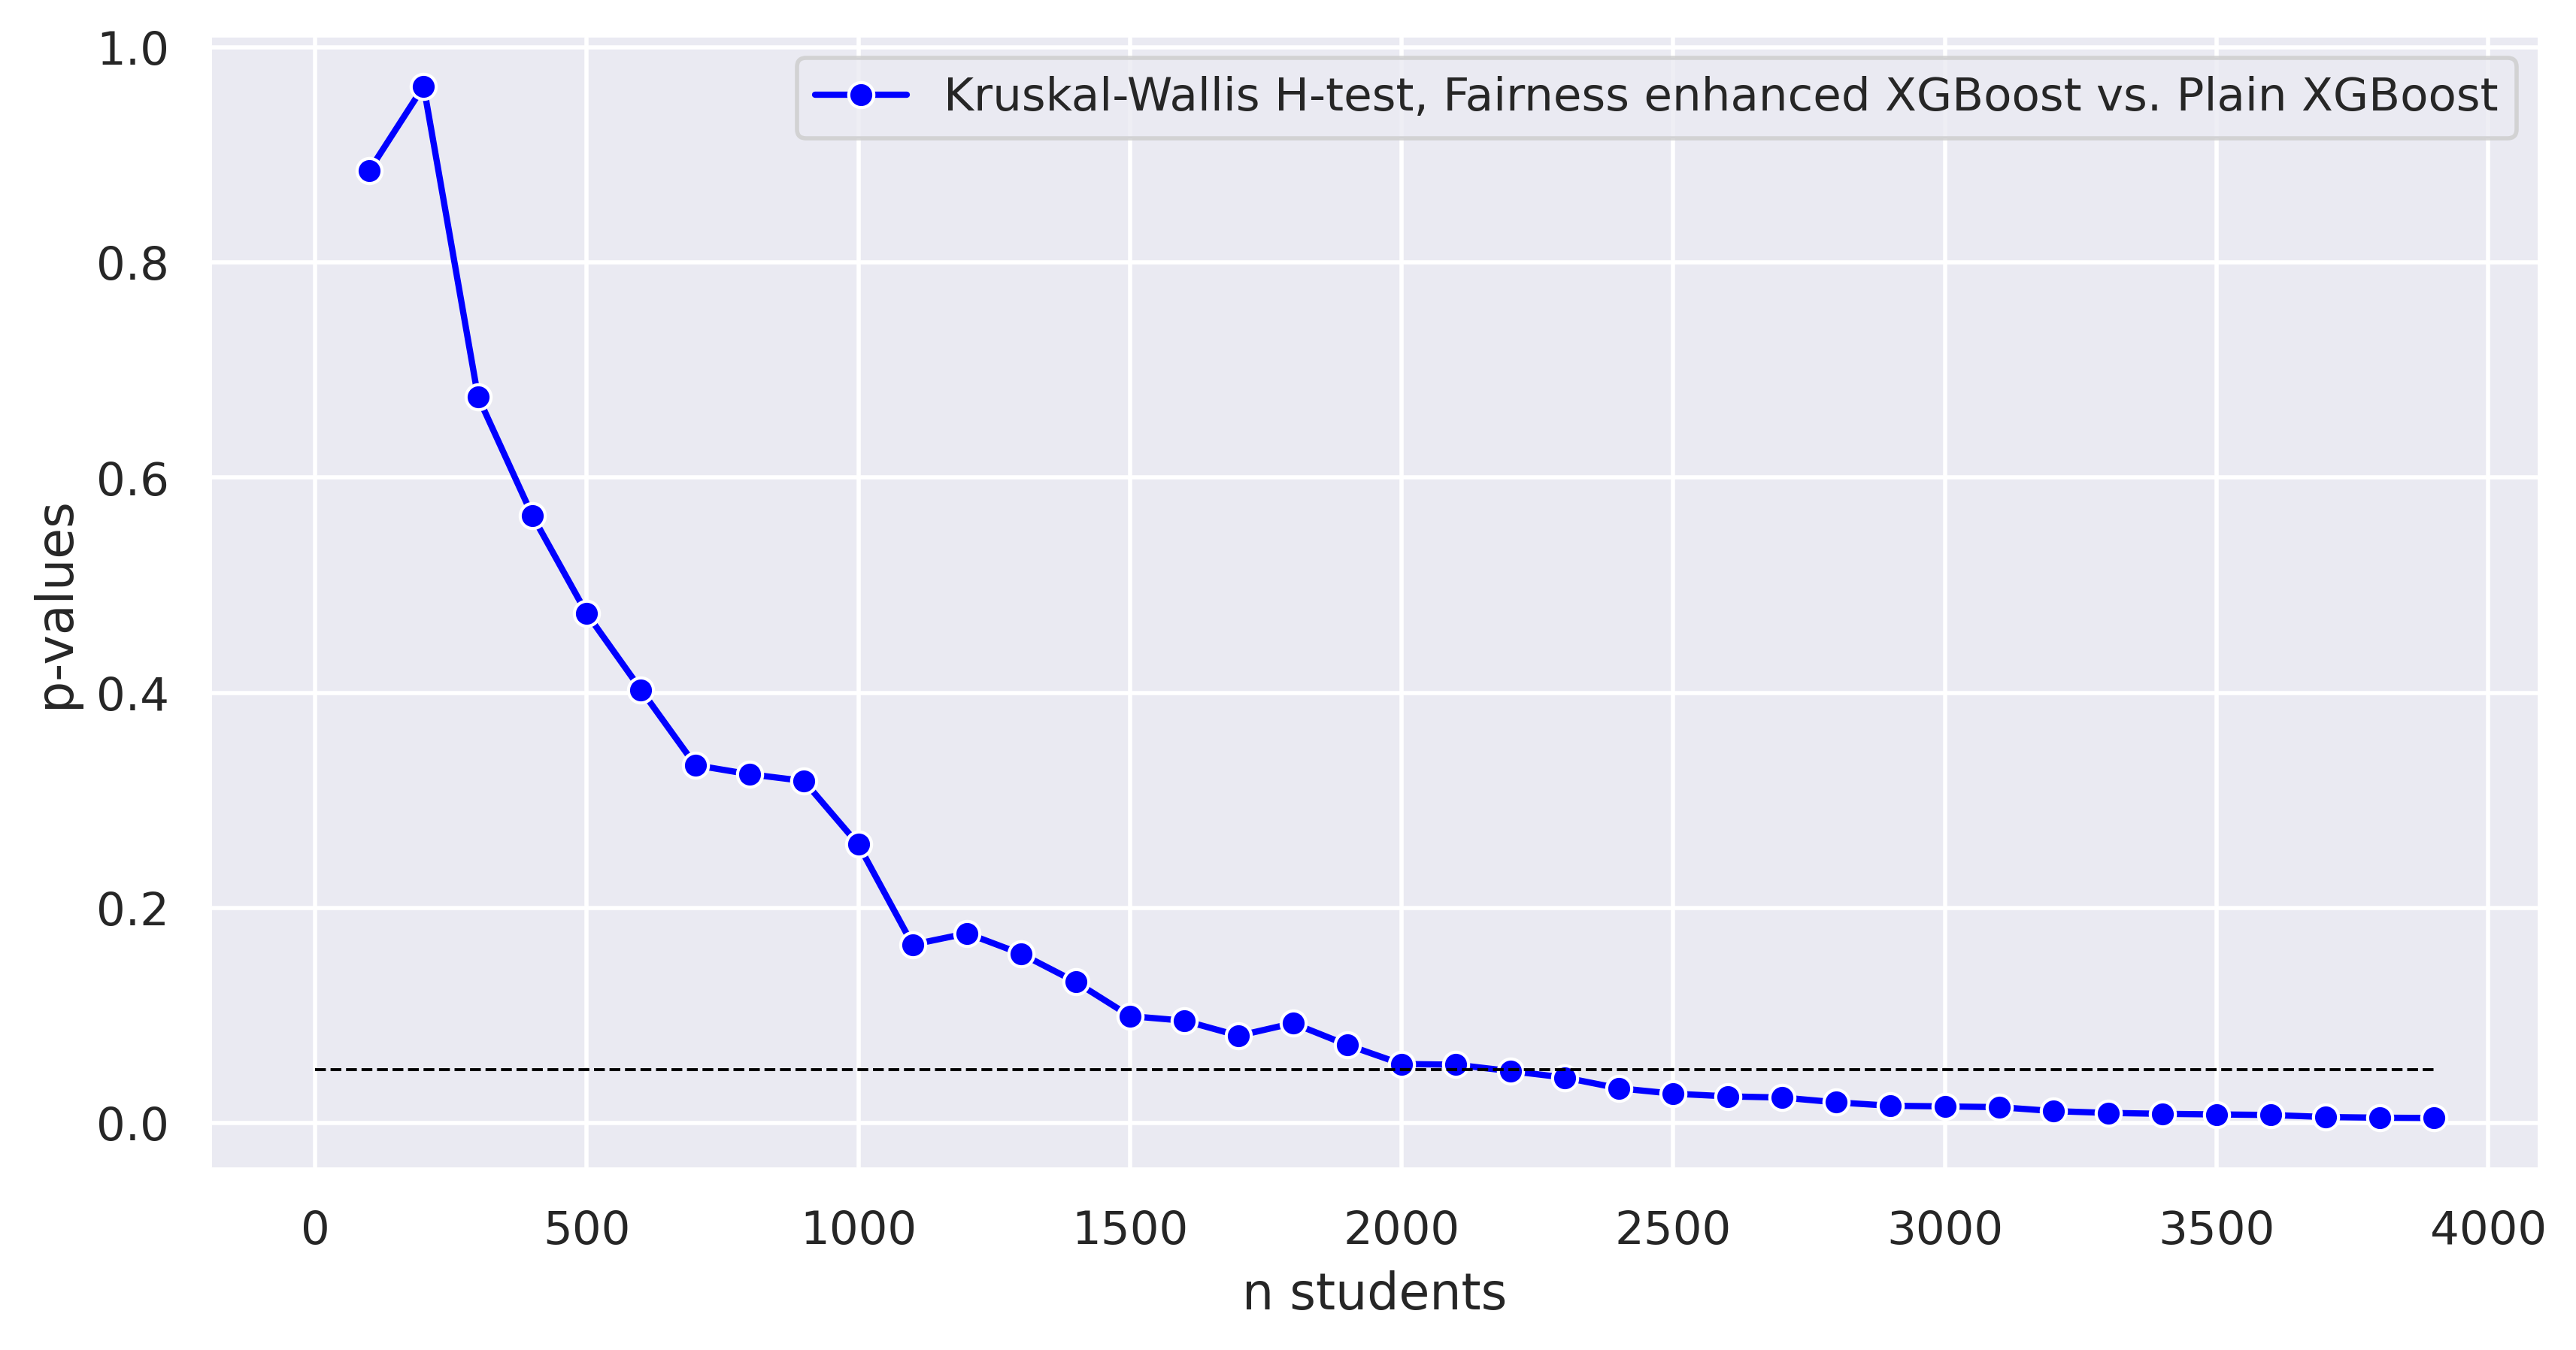

In [50]:

sns.lineplot(y=fair_plain['p_vals'] ,x=fair_plain['n_students'],linestyle='-',color='blue', marker='o', dashes=[(100,0),(10,0),(10,0),(10,0)])
X_plot = np.arange(0,4000,100)
X_plot = fair_plain.n_students

Y_plot = 0.05+X_plot*0
plt.plot(X_plot, Y_plot, color='black', linewidth=0.7, linestyle='--')

plt.xlabel('n students')
plt.ylabel('p-values')
# plt.title('Plain XGBoost significance with other rankers')
plt.legend(["Kruskal-Wallis H-test, Fairness enhanced XGBoost vs. Plain XGBoost"], loc ="upper right")

plt.show()
# sns.histplot(data=Merged_PLAIN[0:500],  x="COL_GRADE_AVG")
# sns.histplot(data=GT[:500],  x="y_test",color='red', alpha=0.3 )